#Inicialización

En primer lugar se inicializan las bibliotecas necesarias para la realización del proyecto.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files

In [2]:
!pip install git+https://github.com/helias/shap.git@support-adaboost

  Cloning https://github.com/helias/shap.git (to revision support-adaboost) to /tmp/pip-req-build-armdls12
  Running command git clone --filter=blob:none --quiet https://github.com/helias/shap.git /tmp/pip-req-build-armdls12
  Running command git checkout -b support-adaboost --track origin/support-adaboost
  Switched to a new branch 'support-adaboost'
  Branch 'support-adaboost' set up to track remote branch 'support-adaboost' from 'origin'.
  Resolved https://github.com/helias/shap.git to commit 06ebfdd29b28191a1faac992c9b5c246b2d70a54
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import shap

Ahora, se importa en este cuaderno el archivo .xslx con los datos de estudio,procesando el objeto en memoria.

In [4]:
def upload_files(index_fields=None):
  uploaded = files.upload()
  for filename in uploaded.keys():
    df = pd.read_excel(io.BytesIO(uploaded[filename]), index_col = index_fields)
    return df

In [5]:
cancer_data = upload_files()

Saving Supplementary data 1.xlsx to Supplementary data 1 (1).xlsx


#Conocimiento y preprocesamiento de los datos

## Descubrimiento de los datos

Se inicializa el descubrimiento de los datos comprobando tanto su forma (número de filas y columnas) como el tipo de datos.

In [6]:
print(f"El tamaño del dataset a utilizar es: ", cancer_data.shape)

El tamaño del dataset a utilizar es:  (349, 51)


In [7]:
cancer_data.dtypes

SUBJECT_ID      int64
AFP            object
AG            float64
Age             int64
ALB           float64
ALP           float64
ALT           float64
AST           float64
BASO#         float64
BASO%         float64
BUN           float64
Ca            float64
CA125          object
CA19-9         object
CA72-4        float64
CEA           float64
CL            float64
CO2CP         float64
CREA          float64
TYPE            int64
DBIL          float64
EO#           float64
EO%           float64
GGT           float64
GLO           float64
GLU.          float64
HCT           float64
HE4           float64
HGB           float64
IBIL          float64
K             float64
LYM#          float64
LYM%          float64
MCH           float64
MCV           float64
Menopause       int64
Mg            float64
MONO#         float64
MONO%         float64
MPV           float64
Na            float64
NEU           float64
PCT           float64
PDW           float64
PHOS          float64
PLT       

Sorprende que haya tres columnas de tipo objeto, por lo que se visualizan estas para ver donde esta el "fallo".

In [8]:
object_columns = cancer_data.select_dtypes(include=['object'])
for column in object_columns:
  print(column)
  for value in cancer_data[column]:
    if isinstance(value, str):
      print(value)

AFP
3.58	
34.24	
1.50	
3.03	
1.01	
1.93	
4.00	
2.54	
4.64	
2.70	
1.60	
3.18	
1.70	
1.42	
2.88	
2.00	
2.02	
8.06	
3.46	
2.75	
0.77	
2.16	
2.02	
2.20	
5.70	
1.92	
2.60	
2.98	
4.87	
3.58	
4.50	
3.28	
2.44	
2.30	
1.80	
3.69	
2.20	
>1210.00
1.76	
2.73	
1.86	
1.68	
2.42	
2.71	
1.51	
13.02	
1.53	
0.70	
1.50	
2.94	
3.20	
1.96	
1.74	
1.85	
4.16	
1.53	
1.83	
1.22	
2.42	
1.49	
3.86	
4.03	
2.64	
2.99	
4.28	
1.69	
1.89	
1.32	
1.88	
2.26
3.11
5.02
1.63
4.76
3.13
4.66
2.88
>1210
1.88
1.75
2.27
5.00
3.15
2.03
3.63
3.70
3.32
1.95
1.67
1.92
9.07
2.29
5.03
2.87
CA125
15.36	
2444.00	
56.08	
39.83	
48.14	
16.65	
3271.00	
4468.00	
259.30	
450.00	
27.80	
71.80	
121.10	
389.30	
196.90	
446.20	
237.40	
1280.00	
516.50	
386.70	
396.80	
22.84	
106.30	
2193.00	
48.84	
476.00	
886.50	
21.95	
14.81	
675.70	
42.63	
2741.00	
7.33	
224.20	
377.10	
1777.00	
77.32	
275.70	
124.30	
3950.00	
255.50	
>5000.00	
294.80	
169.80	
228.90	
740.20	
913.90	
21.24	
428.00	
1717.00	
554.80	
448.40	
1823.00	
431.50	
35.56	
13.54	
172

Para las columnas de tipo objeto, se ve que algunos valores contienen espacios en blanco al final, por lo que se eliminan estos espacios en blanco

In [9]:
cancer_data[object_columns.columns] = object_columns.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Las columnas de tipo 'object' tienen también algunos valores inconsistentes, por lo que se modifican estos para poder cambiar el tipo

In [10]:
cancer_data.loc[cancer_data['AFP'] == '>1210.00', 'AFP'] = '1210.00'
cancer_data.loc[cancer_data['AFP'] == '>1210', 'AFP'] = '1210.00'
cancer_data.loc[cancer_data['CA125'] == '>5000.00', 'CA125'] = '5000.00'
cancer_data.loc[cancer_data['CA19-9'] == '>1000.00', 'CA19-9'] = '1000.00'
cancer_data.loc[cancer_data['CA19-9'] == '>1000', 'CA19-9'] = '1000.00'
cancer_data.loc[cancer_data['CA19-9'] == '<0.600', 'CA19-9'] = '0.60'

Se cambia el tipo de las columnas de tipo object para que sean de tipo float

In [11]:
for column in cancer_data.drop('TYPE', axis=1).select_dtypes(include=['object']).columns:
    cancer_data[column] = cancer_data[column].astype('float')

Se realiza el análisis estadístico descriptivo de las columnas

In [12]:
pd.set_option('display.max_columns', None)
cancer_data.drop('TYPE', axis=1).describe()

SUBJECT_ID          AFP          AG         Age         ALB  \
count  349.000000   327.000000  348.000000  349.000000  339.000000   
mean   196.232092    11.822875   19.320517   45.051576   41.076991   
std    126.944872    98.231126    4.348675   15.130949    5.686780   
min      1.000000     0.610000    6.200000   15.000000   22.000000   
25%     88.000000     1.620000   17.287500   33.000000   38.300000   
50%    175.000000     2.280000   19.850000   45.000000   42.000000   
75%    327.000000     3.455000   22.177500   57.000000   45.300000   
max    414.000000  1210.000000   33.330000   83.000000   51.500000   

              ALP         ALT         AST       BASO#       BASO%         BUN  \
count  339.000000  339.000000  339.000000  349.000000  349.000000  349.000000   
mean    77.085546   18.011799   19.106195    0.028883    0.479771    4.011117   
std     44.375700   11.243664    8.495069    0.020890    0.346230    1.285569   
min     26.000000    4.000000    7.000000    0.000000    0.000000    1.120000   
25%     60.000000   11.000000   13.500000    0.010000    0.200000    3.160000   
50%     71.000000   15.000000   17.000000    0.030000    0.400000    3.830000   
75%     87.000000   21.000000   22.000000    0.040000    0.700000    4.780000   
max    763.000000   86.000000   78.000000    0.120000    1.940000   10.190000   

               Ca        CA125       CA19-9      CA72-4         CEA  \
count  349.000000   332.000000   325.000000  109.000000  327.000000   
mean     2.390630   350.382681    46.733938   10.173394    3.309083   
std      0.364975   796.488080   125.905844   25.232650   11.037197   
min      0.920000     3.750000     0.600000    0.200000    0.200000   
25%      2.320000    19.160000     7.810000    1.060000    0.830000   
50%      2.470000    44.675000    14.200000    2.370000    1.330000   
75%      2.580000   248.075000    30.940000    6.420000    2.065000   
max      2.830000  5000.000000  1000.000000  158.500000  138.800000   

               CL       CO2CP        CREA        DBIL         EO#         EO%  \
count  349.000000  348.000000  349.000000  339.000000  349.000000  349.000000   
mean   100.812894   24.277874   64.250143    3.128614    0.066017    1.119112   
std      2.985526    2.687284   11.714643    1.434953    0.067704    1.134829   
min     84.600000   16.200000   38.200000    0.900000    0.000000    0.000000   
25%     99.200000   22.400000   56.000000    2.200000    0.020000    0.300000   
50%    100.900000   24.050000   63.300000    2.800000    0.050000    0.800000   
75%    102.600000   26.025000   71.000000    3.700000    0.090000    1.500000   
max    109.400000   34.300000  114.000000   12.100000    0.400000    7.600000   

              GGT         GLO        GLU.         HCT          HE4  \
count  339.000000  339.000000  349.000000  349.000000   329.000000   
mean    21.312684   30.176696    5.334986    0.383874   183.948967   
std     18.170043    4.545036    1.215904    0.042177   380.372693   
min      4.000000   14.100000    3.570000    0.224000    16.710000   
25%     12.000000   27.000000    4.660000    0.362000    42.200000   
50%     16.000000   30.100000    5.080000    0.388000    53.270000   
75%     23.000000   32.800000    5.600000    0.410000   130.600000   
max    176.000000   47.600000   12.440000    0.569000  3537.600000   

              HGB        IBIL           K        LYM#        LYM%         MCH  \
count  349.000000  339.000000  349.000000  349.000000  349.000000  349.000000   
mean   125.336103    5.961062    4.386447    1.557593   26.070831   28.777192   
std     15.534192    2.953268    0.396798    0.561449   10.386006    2.569315   
min     61.800000    1.000000    3.080000    0.350000    3.900000   17.700000   
25%    119.000000    4.000000    4.150000    1.190000   18.400000   28.000000   
50%    127.000000    5.400000    4.370000    1.500000   26.600000   29.300000   
75%    135.000000    7.300000    4.650000    1.870000   32.800000   30.400000 

## Tratamiento de valores nulos

Se visualiza mapa de calor para el estudio de nulos

<Axes: >

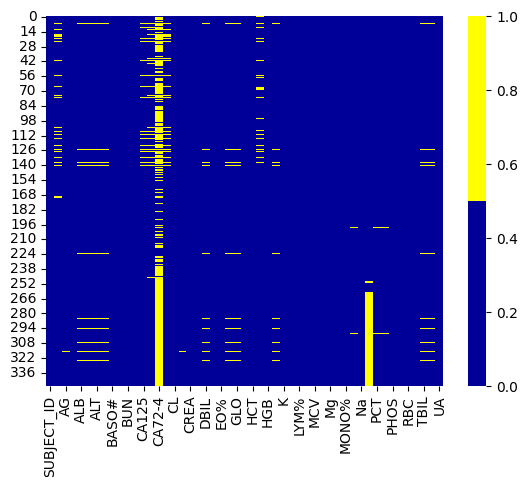

In [13]:
colours = ['#000099', '#ffff00']
sns.heatmap(cancer_data.isnull(), cmap=sns.color_palette(colours))

Aunque este mapa de calor ya empieza a dar algo de información, se evalúa el ratio de valores faltantes en cada columna:

In [14]:
ratio = cancer_data.isnull().mean()
print(ratio)

SUBJECT_ID    0.000000
AFP           0.063037
AG            0.002865
Age           0.000000
ALB           0.028653
ALP           0.028653
ALT           0.028653
AST           0.028653
BASO#         0.000000
BASO%         0.000000
BUN           0.000000
Ca            0.000000
CA125         0.048711
CA19-9        0.068768
CA72-4        0.687679
CEA           0.063037
CL            0.000000
CO2CP         0.002865
CREA          0.000000
TYPE          0.000000
DBIL          0.028653
EO#           0.000000
EO%           0.000000
GGT           0.028653
GLO           0.028653
GLU.          0.000000
HCT           0.000000
HE4           0.057307
HGB           0.000000
IBIL          0.028653
K             0.000000
LYM#          0.000000
LYM%          0.000000
MCH           0.000000
MCV           0.000000
Menopause     0.000000
Mg            0.000000
MONO#         0.000000
MONO%         0.000000
MPV           0.005731
Na            0.000000
NEU           0.260745
PCT           0.005731
PDW        

Se van a eliminar las columnas que tienen un radio mayor a 0.3, ya que no pueden aportar mucho al modelo y si los rellenasemos con otros valores "inventados" no tendría mucho sentido. Las columnas con pocos datos faltantes se van a tratar modificando estos por la mediana de los valores, ya que en los casos en los que haya outliers la media puede venir sesgada por estos.

In [15]:
cancer_data.drop(columns= ratio[ratio >= 0.3].index, inplace=True)

for column in cancer_data.columns:
    median_value = cancer_data[column].median()
    cancer_data[column].fillna(median_value, inplace=True)


## Tratamiento de outliers

Se procede ahora al estudio de valores atípicos en cada una de las columnas usando la medida z-score, la cuál indica cuántas desviaciones estándar un punto de datos específico está por encima o por debajo de la media del conjunto de datos. Para poder usar la medida z-score hay que comprobar primero si las columnas están distribuidas normalmente o no, en cuyo caso habría que utilizar un z-score modificado. Para comprobar la distribución de las columnas dibujaremos un histograma para cada una de ellas.

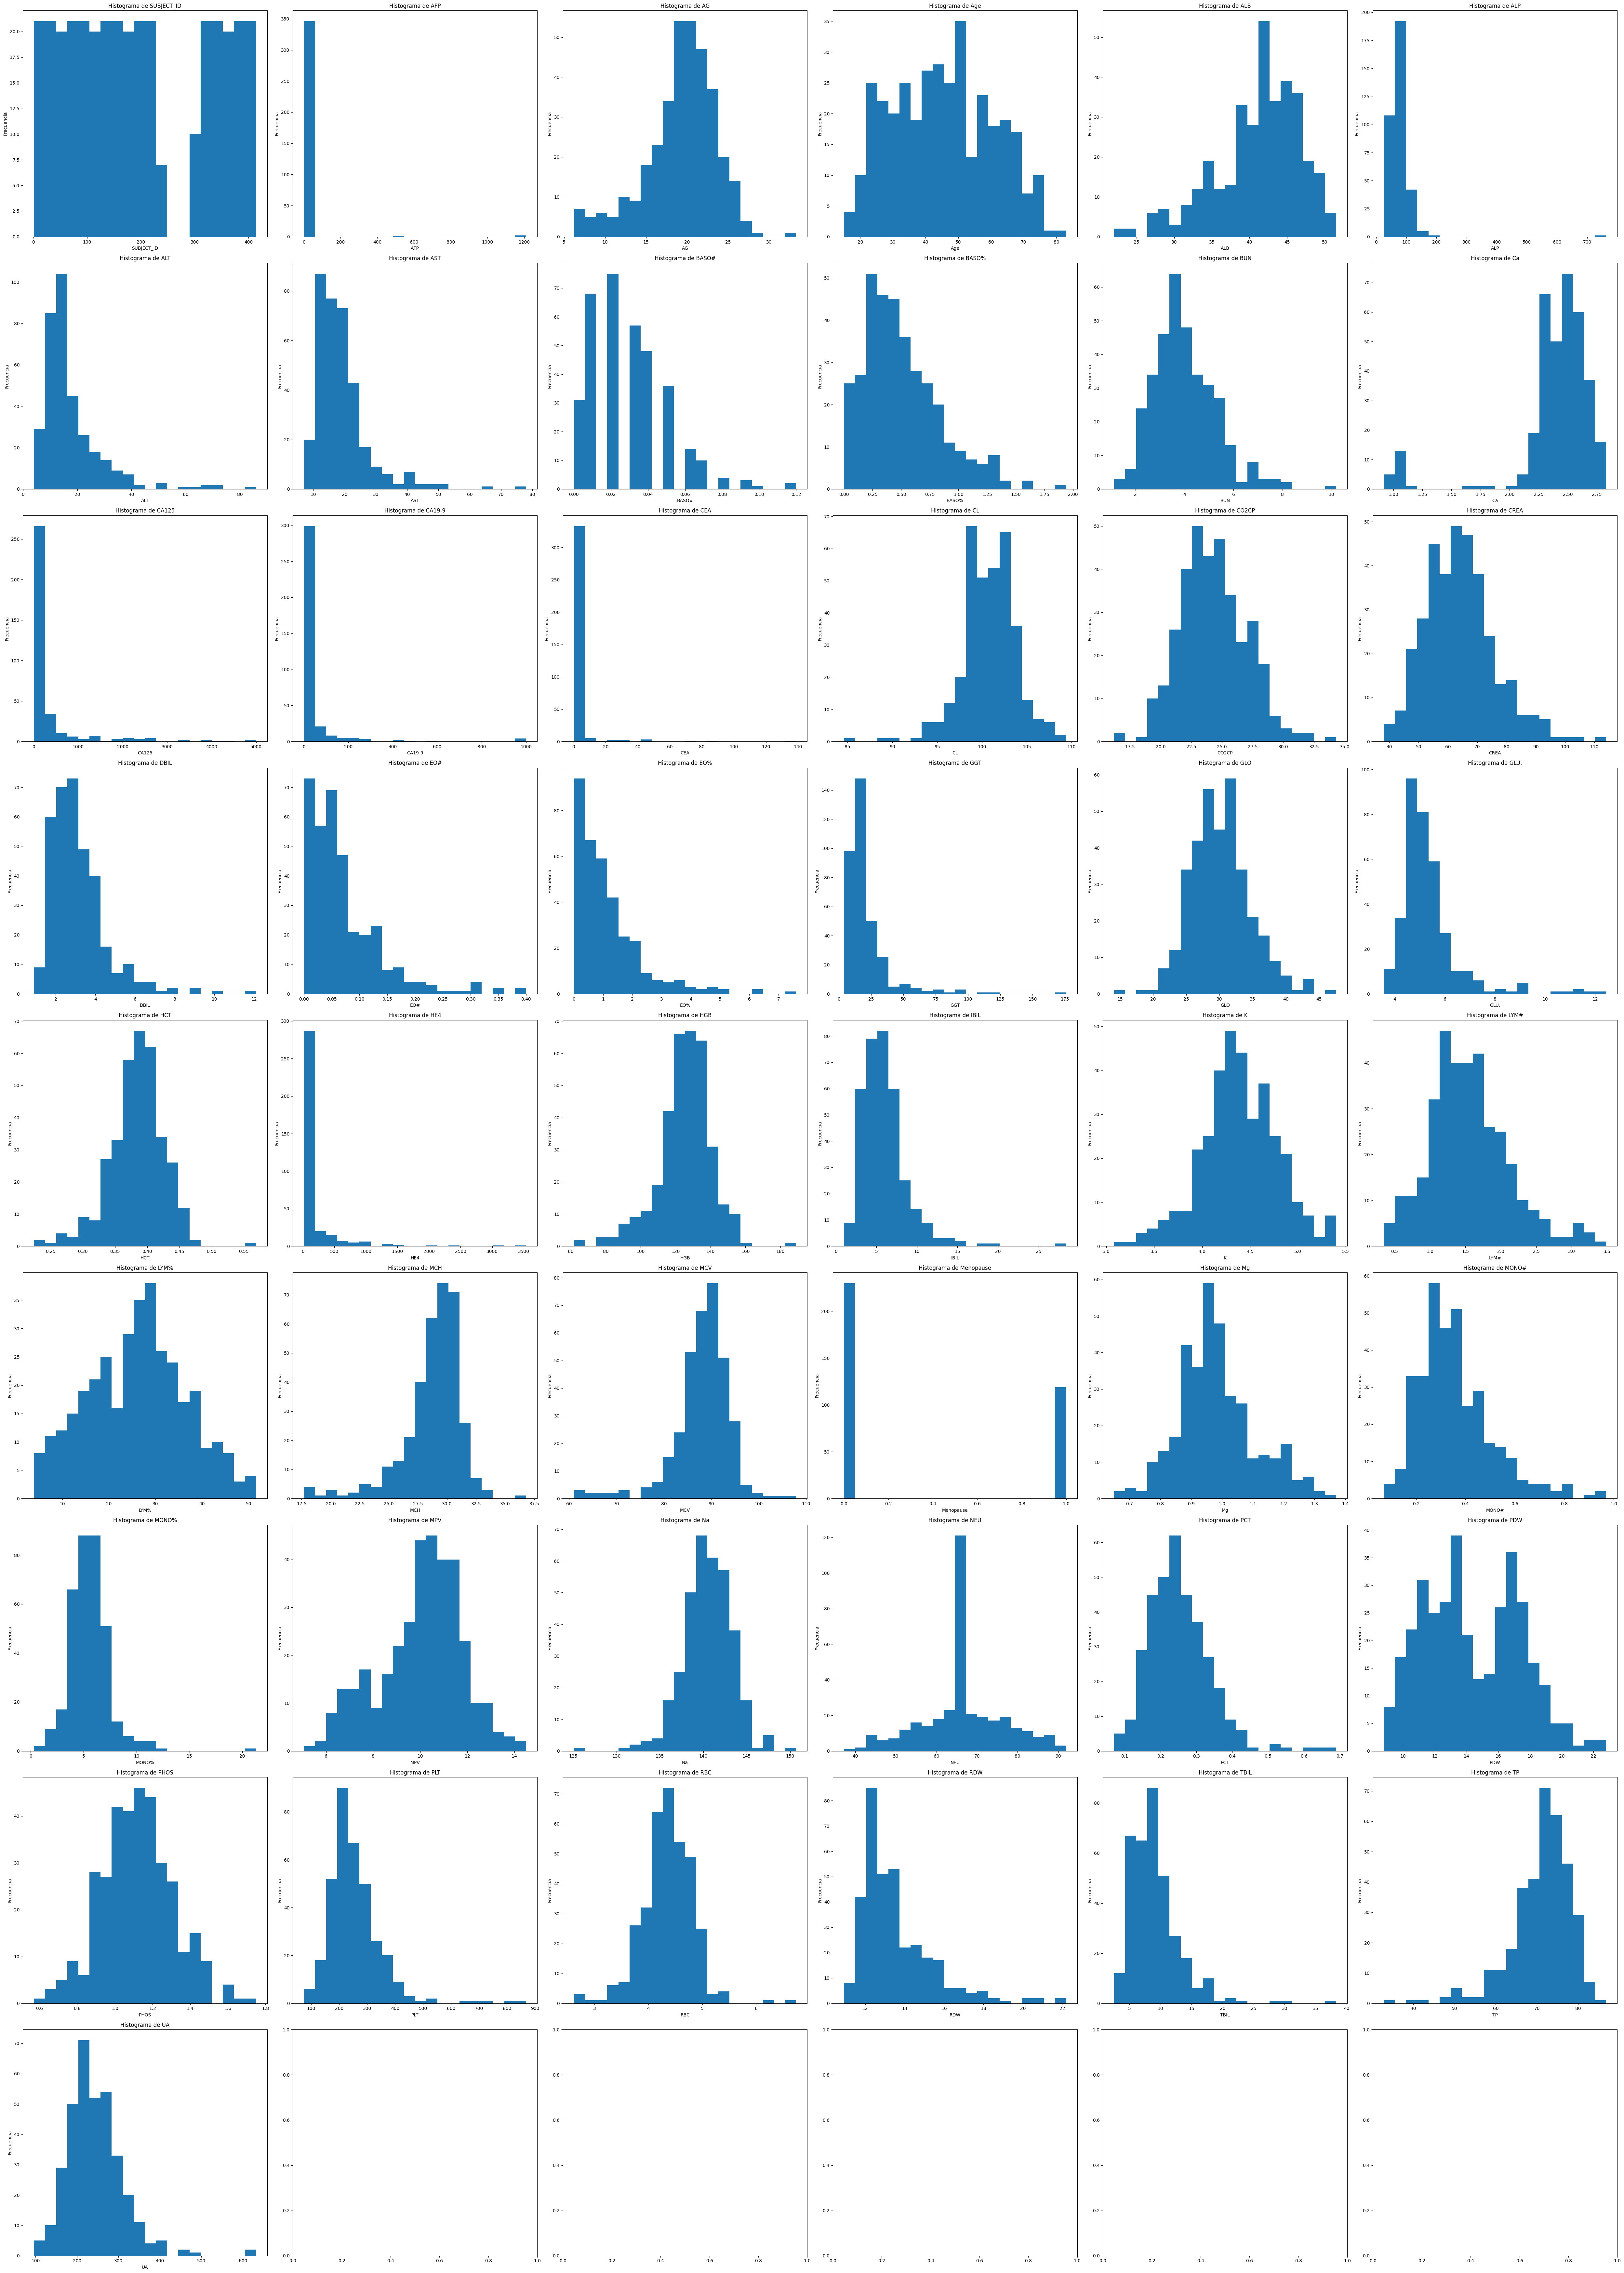

In [16]:
column_names = cancer_data.columns.drop('TYPE')
num_cols = 6
num_rows = (len(column_names) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50,70))
plt.subplots_adjust(wspace=2.5, hspace=2.5)

for i, column in enumerate(column_names):
    row, col = divmod(i, num_cols)
    axes[row, col].hist(cancer_data[column], bins=20)
    axes[row, col].set_title(f'Histograma de {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Primera perspectiva**

Como muchas de las columnas no están distribuidas normalmente, se va a aplicar el z-score modificado para todas ellas, el cuál mide cuánto se aleja un valor de la mediana en términos de la desviación absoluta mediana.
Se elige un threshold = 3.5, ya que Iglewicz y Hoaglin recomiendan que los valores con puntuaciones z modificadas inferiores a -3,5 o superiores a 3,5 se etiqueten como posibles valores atípicos.

In [17]:
threshold = 3.5
outliers_data = []

for column in cancer_data.columns.drop('TYPE'):
    median_value = cancer_data[column].median()
    MAD = abs(cancer_data[column] - median_value).median()

    if MAD != 0:
        modified_z_scores = 0.6745 * (cancer_data[column] - median_value) / MAD
    else:
        mean_value = cancer_data[column].mean()
        MeanAD = abs(cancer_data[column] - mean_value).mean()
        modified_z_scores = 0.7979 * (cancer_data[column] - mean_value) / MeanAD

    total_outliers = np.sum(np.abs(modified_z_scores) >= threshold)

    outliers_data.append([column, total_outliers])

outliers = pd.DataFrame(outliers_data, columns=['Column', 'Total_Outliers'])
print(outliers)

        Column  Total_Outliers
0   SUBJECT_ID               0
1          AFP              17
2           AG               5
3          Age               0
4          ALB               3
5          ALP               7
6          ALT              22
7          AST              16
8        BASO#               6
9        BASO%               3
10         BUN               5
11          Ca              21
12       CA125              91
13      CA19-9              44
14         CEA              23
15          CL               3
16       CO2CP               1
17        CREA               3
18        DBIL              11
19         EO#              15
20         EO%              18
21         GGT              25
22         GLO               2
23        GLU.              16
24         HCT               6
25         HE4              87
26         HGB               7
27        IBIL               8
28           K               1
29        LYM#               2
30        LYM%               0
31      

Se van a tratar aquellas columnas que tienen más de 10 outliers, pero primero se va a ver sus box-plots

**Segunda perspectiva**

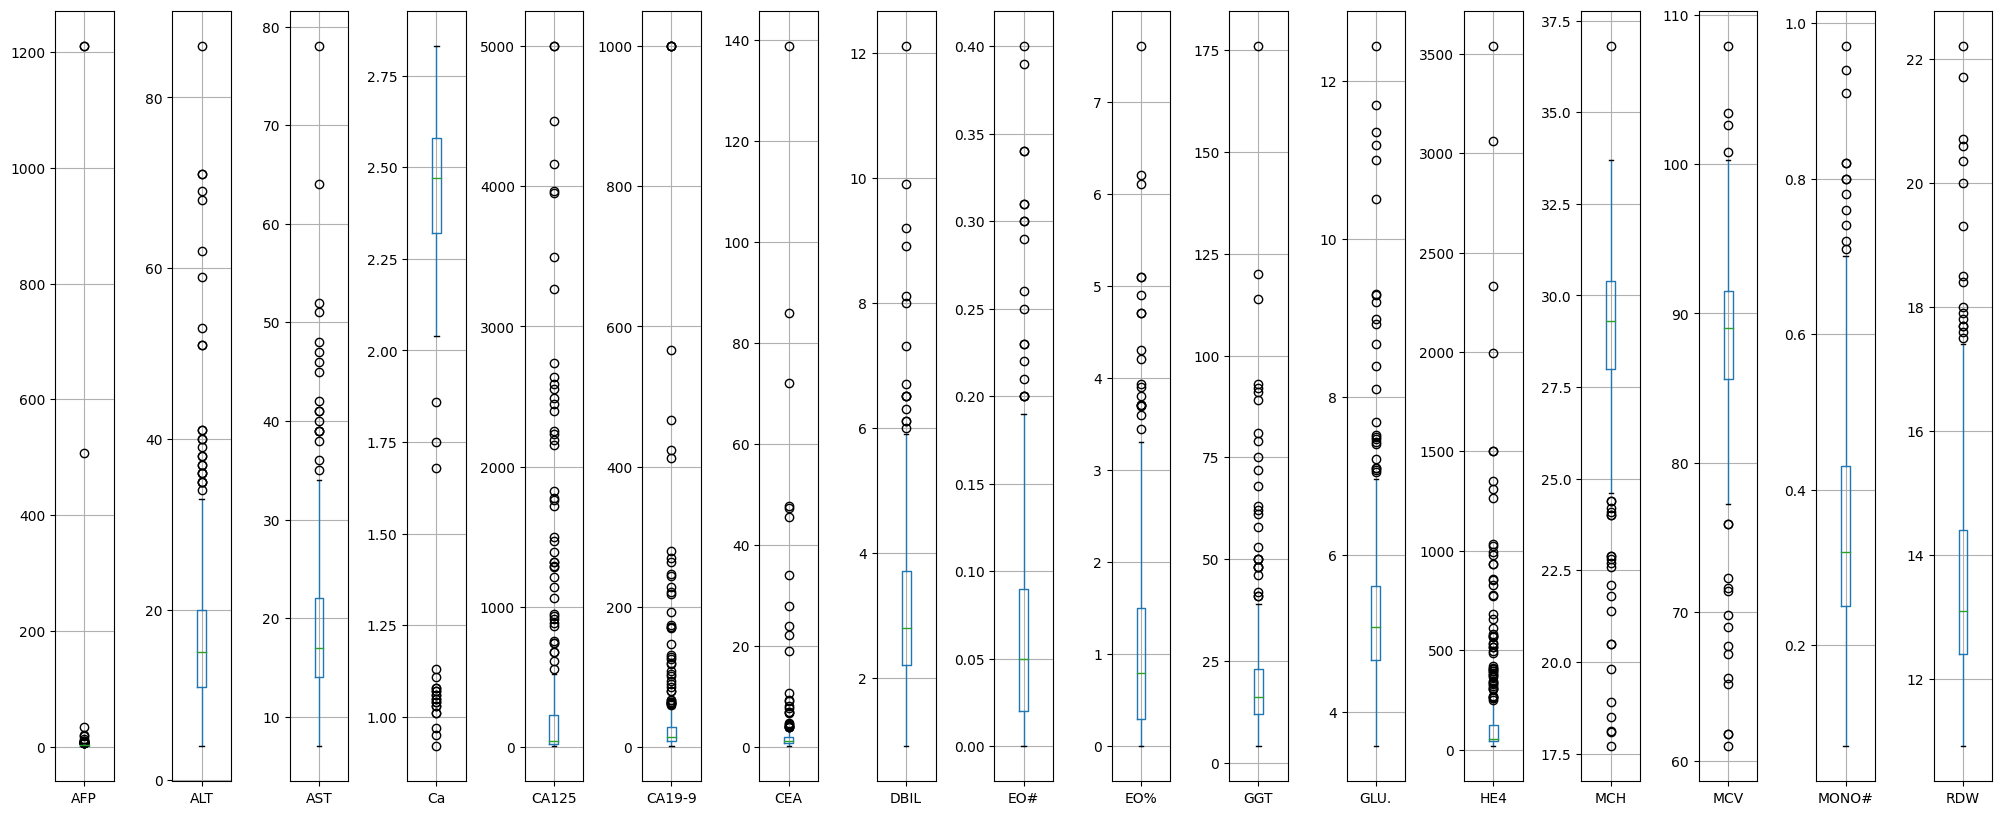

In [18]:
columns = outliers[outliers['Total_Outliers'] >= 10]['Column'].tolist()

fig,ax = plt.subplots(ncols=len(columns), figsize=(25,10))
plt.subplots_adjust(wspace=1)

for i, column in enumerate(columns):
    cancer_data.boxplot([column], ax=ax[i])

In [19]:
def calculate_boxplot_limits(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

for column in columns:
    lower_bound, upper_bound = calculate_boxplot_limits(cancer_data[column])
    outliers_below = cancer_data[column] < lower_bound
    outliers_above = cancer_data[column] > upper_bound
    count_outliers_below = outliers_below.sum()
    count_outliers_above = outliers_above.sum()

    print(f"Column {column}: {count_outliers_below} outliers below {lower_bound}")
    print(f"Column {column}: {count_outliers_above} outliers above {upper_bound}")
    print('------------')

Column AFP: 0 outliers below -0.7300000000000004
Column AFP: 22 outliers above 5.67
------------
Column ALT: 0 outliers below -2.5
Column ALT: 26 outliers above 33.5
------------
Column AST: 0 outliers below 2.0
Column AST: 18 outliers above 34.0
------------
Column Ca: 22 outliers below 1.9299999999999995
Column Ca: 0 outliers above 2.9700000000000006
------------
Column CA125: 0 outliers below -292.55
Column CA125: 45 outliers above 541.77
------------
Column CA19-9: 0 outliers below -21.27
Column CA19-9: 44 outliers above 57.69
------------
Column CEA: 0 outliers below -0.9349999999999999
Column CEA: 27 outliers above 3.825
------------
Column DBIL: 0 outliers below -0.04999999999999982
Column DBIL: 15 outliers above 5.95
------------
Column EO#: 0 outliers below -0.08499999999999998
Column EO#: 18 outliers above 0.19499999999999998
------------
Column EO%: 0 outliers below -1.4999999999999998
Column EO%: 19 outliers above 3.3
------------
Column GGT: 0 outliers below -4.5
Column GG

No se quieren eliminar los valores atípicos ya que no se cree que sea un error en la entrada de los datos, simplemente se quieren suavizar estos para que no influyan demasiado.

In [20]:
from scipy.stats.mstats import winsorize
for column in columns:
  lower_bound, upper_bound = calculate_boxplot_limits(cancer_data[column])
  outliers_below = cancer_data[column] < lower_bound
  outliers_above = cancer_data[column] > upper_bound

  outlier_prop = (outliers.loc[outliers['Column'] == column, 'Total_Outliers'].iloc[0]) / len(cancer_data[column])

  if outliers_above.any():
    limits = [0, 0.2] if outlier_prop > 0.05 else [0, 0.1]
    cancer_data[column] = winsorize(cancer_data[column], limits=limits, inplace = True)

  if outliers_below.any():
    limits = [0.2, 0] if outlier_prop > 0.05 else [0.1, 0]
    cancer_data[column] = winsorize(cancer_data[column], limits=limits, inplace = True)

## Balanceo de clases

Se comprueba ahora qué tal de balanceada esta la clase de salida (si la proporción de 0 y 1 es equitativa)

In [21]:
print(f"El número de 0 (presencia de cáncer de ovario) en la variable de salida es:", len(cancer_data[cancer_data['TYPE'] == 0]), "lo que conlleva un: ",round(len(cancer_data[cancer_data['TYPE'] == 0])/len(cancer_data[column]),2)," de los datos")
print(f"El número de 1 (tumor benigno) en la variable de salida es:", len(cancer_data[cancer_data['TYPE'] == 1]), "lo que conlleva un: ",round(len(cancer_data[cancer_data['TYPE'] == 1])/len(cancer_data[column]),2)," de los datos")

El número de 0 (presencia de cáncer de ovario) en la variable de salida es: 171 lo que conlleva un:  0.49  de los datos
El número de 1 (tumor benigno) en la variable de salida es: 178 lo que conlleva un:  0.51  de los datos


Viendo esto gráficamente:

Text(0, 0.5, 'Frecuencia')

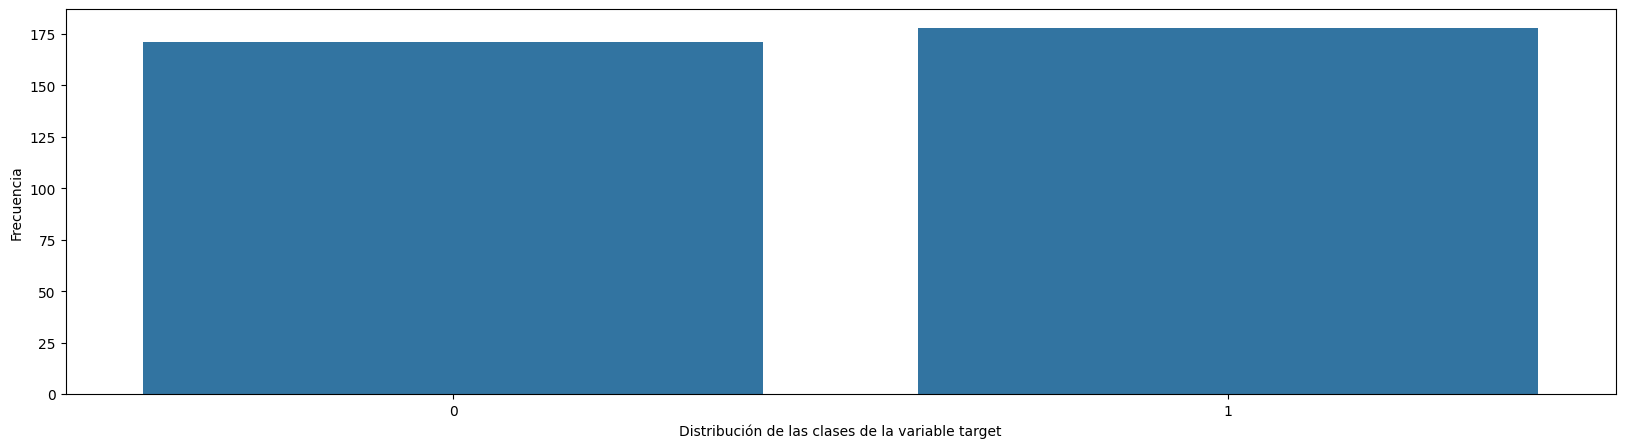

In [22]:
plt.figure(figsize=(20, 5))
sns.countplot(x = cancer_data['TYPE'], data = cancer_data)
plt.xlabel('Distribución de las clases de la variable target')
plt.ylabel('Frecuencia')

#Características

Lo primero que se va a hacer es eliminar la columna de 'SUBJECT_ID' ya que no aporta informción al modelo

In [23]:
cancer_data.drop(columns = 'SUBJECT_ID', inplace = True)

## Correlación entre las variables con variable objetivo

Se estudia la correlación de las variables con la variable salida ('TYPE')

HE4          0.650330
CA125        0.538408
Age          0.514098
Menopause    0.455770
ALB          0.375415
NEU          0.353062
LYM%         0.315035
PLT          0.270182
LYM#         0.256494
PCT          0.243719
AST          0.214474
ALP          0.213249
DBIL         0.201367
IBIL         0.200451
HGB          0.197863
MONO#        0.197812
TBIL         0.195921
GLO          0.195630
TP           0.193353
MCH          0.186165
Ca           0.177572
GLU.         0.158334
Na           0.143849
PDW          0.138127
GGT          0.128794
HCT          0.124177
BASO%        0.106780
RBC          0.099632
MONO%        0.097504
CO2CP        0.095392
AFP          0.089750
EO%          0.080286
CREA         0.075397
CA19-9       0.062096
CEA          0.059892
BASO#        0.057404
EO#          0.051660
MCV          0.042493
ALT          0.042399
RDW          0.037714
UA           0.036456
MPV          0.033259
CL           0.028061
PHOS         0.022725
AG           0.018363
Mg        

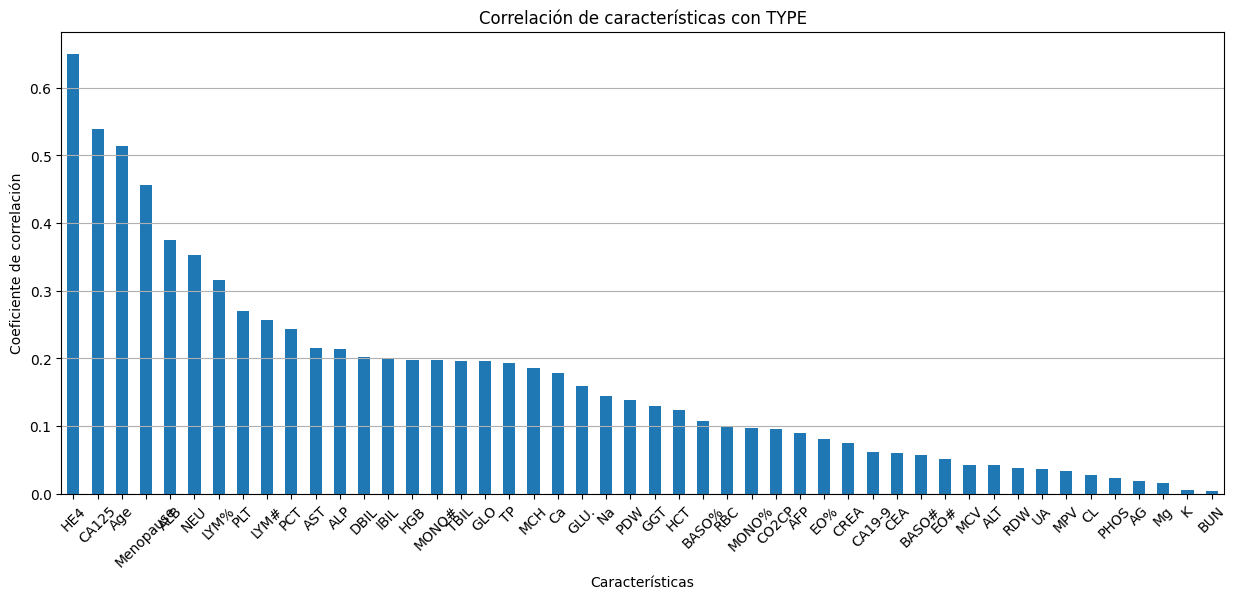

In [24]:
features = cancer_data.columns.tolist()
type_corr = cancer_data[features].corr()['TYPE']
type_corr = type_corr.drop('TYPE', axis=0)
type_corr = abs(type_corr).sort_values(ascending = False)
print(type_corr)

plt.figure(figsize=(15, 6))
type_corr.plot(kind='bar')
plt.title('Correlación de características con TYPE')
plt.xlabel('Características')
plt.ylabel('Coeficiente de correlación')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Se podrían eliminar las características que tienen una correlación <= 0.1 con la variable objetivo

In [25]:
cancer_data.drop(columns= type_corr[type_corr <= 0.1].index, inplace=True)

## Correlación de unas variables con otras

Se estudia la correlación de unas variables con otras. Para empezar se visualiza la matriz de correlación de estas variables.

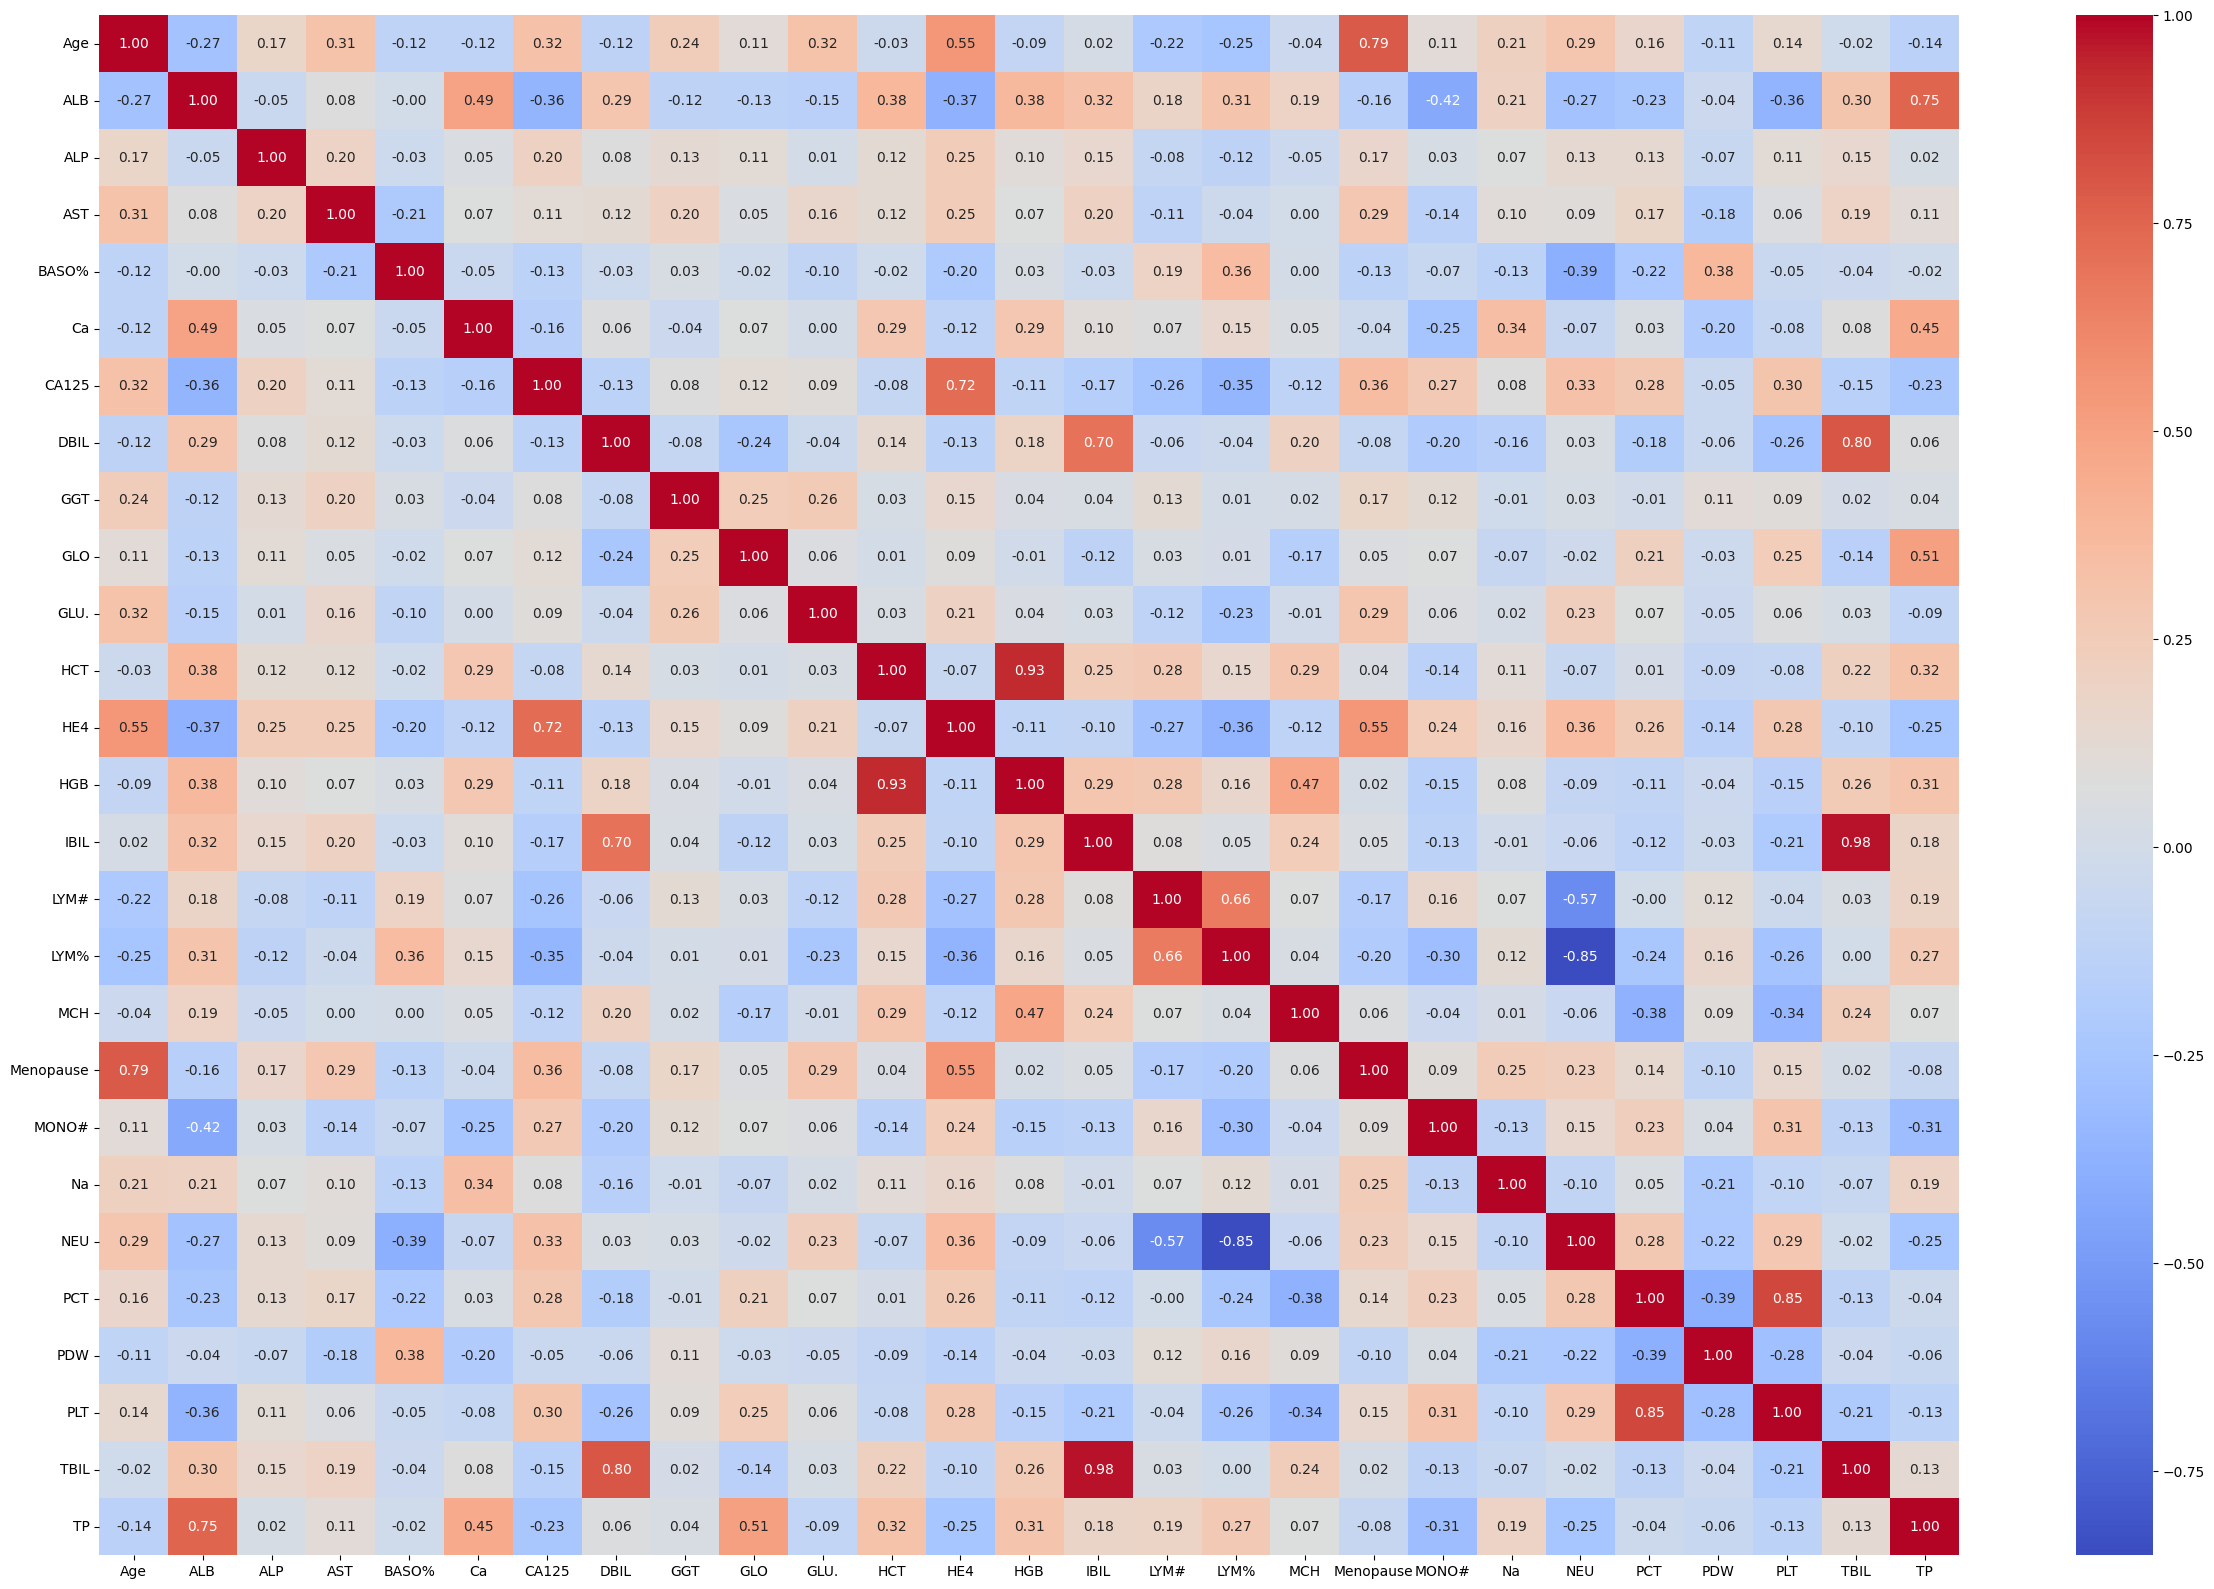

In [26]:
corr_matrix = cancer_data.drop('TYPE', axis = 1).corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Se comprueban los pares de características que están más de un ± 0.85 correlacionadas

In [27]:
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):  # Evita duplicados y la diagonal
        if np.abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for pair in high_corr_pairs:
    print(f"{pair[0]} y {pair[1]} tienen una correlación de {pair[2]}")

HCT y HGB tienen una correlación de 0.9337632349799857
IBIL y TBIL tienen una correlación de 0.9759865686655594
LYM% y NEU tienen una correlación de -0.8511515983023815
PCT y PLT tienen una correlación de 0.8505794257440997


Se mira también mediante un dendograma, habiendo utilizado clustering jerárquico, para ello habrá que normalizar las carácteristicas y eso se hace mediante el algoritmo MinMaxScaler.

In [28]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

columns = cancer_data.drop(columns = ['Menopause', 'TYPE'], axis = 1).columns
x_cancer_data = scaler.fit_transform(cancer_data.drop(['Menopause', 'TYPE'], axis = 1))
x_cancer_data = pd.DataFrame(x_cancer_data, columns = columns)
x_cancer_data.insert(loc=0, column = 'Menopause', value=cancer_data['Menopause'])

y_cancer_data = cancer_data['TYPE']


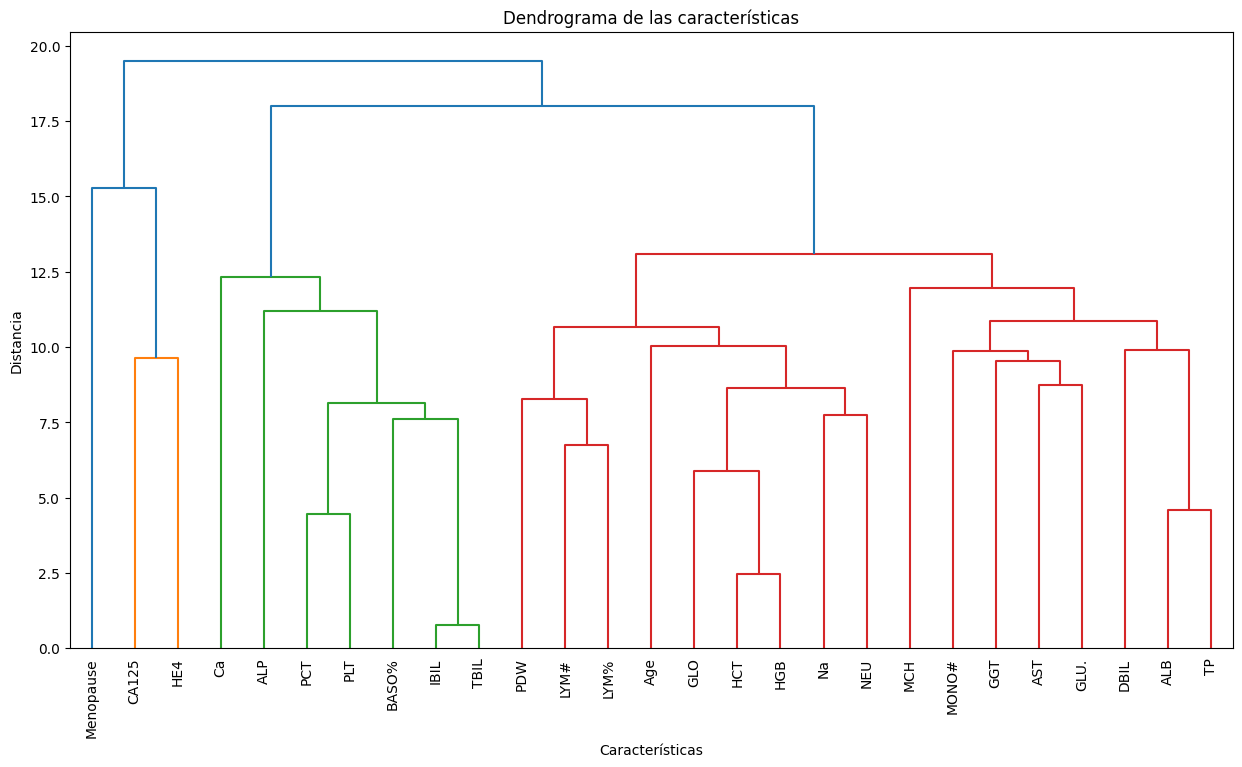

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances
np.random.seed = 42

column_names = x_cancer_data.columns
matdist = pairwise_distances(x_cancer_data.T, metric = 'euclidean')
Z = linkage(matdist, method='average')

plt.figure(figsize=(15, 8))
plt.title('Dendrograma de las características')
plt.xlabel('Características')
plt.ylabel('Distancia')
dendrogram(Z, leaf_rotation=90, labels = column_names)
plt.show()

Se comprueba que efectivamente las características detectadas en la matriz de correlación con una correlación alta, están a una distancia < 5.0 (distancia pequeña) en este clústering jerárquico. Es por eso que se va a eliminar una de las dos características.

Rescatando 'high_corr_pairs', se eliminan las características que menos correlación tienen con TYPE en el par.

In [30]:
cancer_data.drop(columns = ['HCT', 'TBIL', 'LYM%', 'PCT'], inplace = True)

Tras el preprocesamiento de los datos y las características, el dataset que se obtiene es de la siguiente forma:

In [31]:
cancer_data

Age   ALB   ALP   AST  BASO%    Ca   CA125  TYPE  DBIL   GGT   GLO  GLU.  \
0     47  45.4  56.0  24.0   0.30  2.48   15.36     0   2.0  16.0  28.5  4.67   
1     61  39.9  95.0  13.0   0.30  2.62  328.00     0   2.6  13.0  32.1  6.32   
2     39  45.4  77.0  18.0   0.60  2.57   56.08     0   4.6  10.0  32.5  4.64   
3     45  39.2  26.0  17.0   0.74  2.35  328.00     0   2.9  17.0  26.9  4.76   
4     45  35.0  47.0  27.0   0.10  2.48  328.00     0   2.2  24.0  31.5  4.07   
..   ...   ...   ...   ...    ...   ...     ...   ...   ...   ...   ...   ...   
344   52  48.6  65.0  27.0   0.00  2.81   50.80     1   3.8  25.0  31.8  5.13   
345   37  46.1  49.0  20.0   0.00  2.29   21.93     1   4.6   9.0  27.4  4.59   
346   59  45.8  83.0  16.0   0.60  2.65   51.33     1   4.0  13.0  22.6  5.90   
347   30  47.8  64.0  22.0   0.30  2.82   53.87     1   3.5  25.0  28.2  5.59   
348   39  44.9  68.0  13.0   0.20  2.58   46.45     1   2.7   8.0  23.7  4.94   

        HE4    HGB  IBIL  LYM#   MCH  Menopause  MONO#     Na    NEU   PDW  \
0     53.27   89.0   3.5  0.65  31.1          0   0.22  141.3  76.20  13.4   
1    161.90  128.0   4.2  1.27  26.2          1   0.41  142.0  76.50  11.2   
2     47.56  131.0  10.1  1.10  28.4          0   0.25  138.9  69.70  15.2   
3    161.90  123.0   8.0  1.73  30.6          1   0.42  139.1  65.50  17.4   
4    161.90  122.0   3.1  1.98  27.7          0   0.55  141.0  59.50  11.9   
..      ...    ...   ...   ...   ...        ...    ...    ...    ...   ...   
344   31.45  142.0   6.9  1.18  31.1          0   0.28  140.8  66.75  10.8   
345   44.44   80.0  11.3  1.39  25.6          0   0.32  137.1  66.75  17.3   
346   42.65  144.0   9.8  1.10  29.4          1   0.13  144.0  66.75  10.4   
347   30.78  154.0   7.8  2.15  28.8          0   0.43  139.2  66.75  13.4   
348   33.42  128.0   5.6  1.52  31.0          0   0.30  139.9  66.75  11.0   

     PLT    TP  
0     74  73.9  
1    304  72.0  
2    112  77.9  
3    339  66.1  
4    272  66.5  
..   ...   ...  
344  219  80.4  
345  262  73.5  
346  221  68.4  
347  398  76.0  
348  224  68.6  

[349 rows x 24 columns]

## Relevancia de las características

Se calcula el MRMR para estudiar que características son más relevantes en los datos antes de realizar cualquier modelo

In [31]:
!pip install mrmr_selection
from mrmr import mrmr_classif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 771.5 kB/s eta 0:00:00


In [32]:
selected_features = mrmr_classif(X= cancer_data.drop('TYPE', axis = 1), y= cancer_data['TYPE'], K=10)
print(selected_features)

100%|██████████| 10/10 [00:01<00:00,  7.87it/s]

['HE4', 'Age', 'CA125', 'ALB', 'Menopause', 'NEU', 'GLO', 'HGB', 'PLT', 'ALP']


Aunque se haya evaluado de forma general este método de relevancia, más adelante se evaluarán técnicas de relevancia de características cuando se realicen los modelos y se escoja el modelo elegido (ej. SHAP)

## Reducción de características

Todos los algoritmos de reducción de características tienen que utilizarse con el dataset ya normalizado

In [33]:
scaler = preprocessing.MinMaxScaler()

columns = cancer_data.drop(columns = ['Menopause', 'TYPE'], axis = 1).columns
x_cancer_data = scaler.fit_transform(cancer_data.drop(['Menopause', 'TYPE'], axis = 1))
x_cancer_data = pd.DataFrame(x_cancer_data, columns = columns)
x_cancer_data.insert(loc=0, column = 'Menopause', value=cancer_data['Menopause'])

y_cancer_data = cancer_data['TYPE']

### PCA

Para realizar la técnica de PCA, habrá que investigar cuál es el número de componentes óptimo, lo cuál se lleva a cabo utilizando el método del codo.

Text(0, 0.5, 'Suma acumulada de variabilidad explicada')

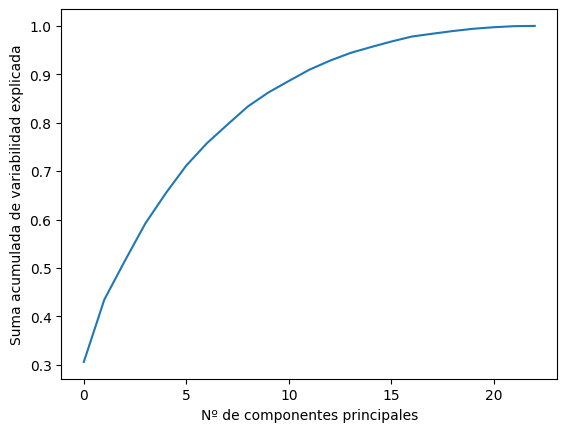

In [34]:
from sklearn.decomposition import PCA
pca = PCA().fit(x_cancer_data)
var = pca.explained_variance_ratio_
np.cumsum(var)
plt.plot(np.cumsum(var))
plt.xlabel("Nº de componentes principales")
plt.ylabel("Suma acumulada de variabilidad explicada")

Se escoge n_componentes = 10, porque es más o menos donde cae la variabilidad explicada en 0.9, y se lleva a cabo la técnica PCA.

In [35]:
pca = PCA(n_components = 10)
pca.fit(x_cancer_data, y_cancer_data)
pca_final = pca.transform(x_cancer_data)
print("\nRatio de variabilidad: ", pca.explained_variance_ratio_, "\n")


Ratio de variabilidad:  [0.30578141 0.12871058 0.07995618 0.07729823 0.06264218 0.05716916
 0.04583217 0.03847973 0.03758926 0.02890235] 



Se visualizan las características iniciales, determinando a qué componente "pertenece" más fuertemente cada variable.

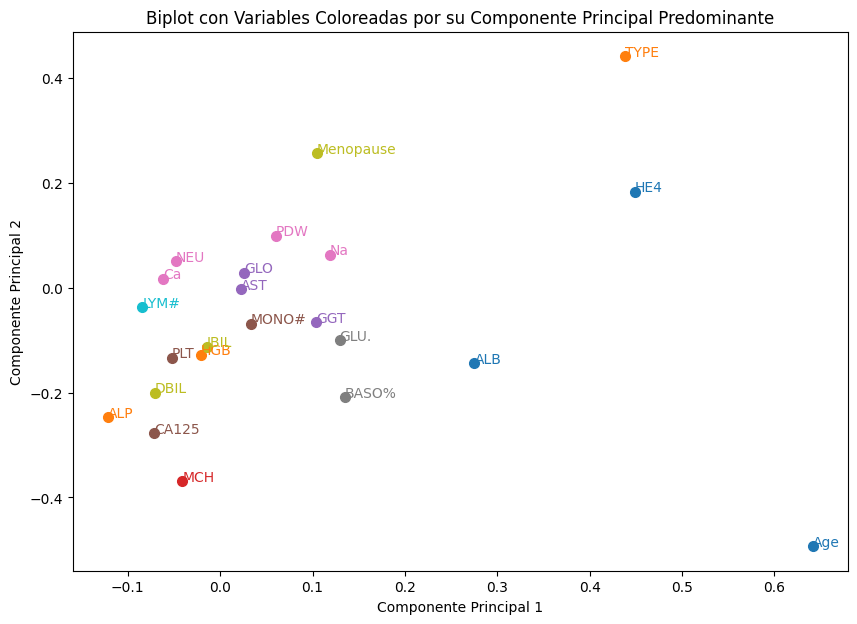

In [36]:
loadings = pca.components_.T

max_loading_indices = np.argmax(np.abs(loadings), axis=1)
num_variables = loadings.shape[0]

plt.figure(figsize=(10, 7))
for i in range(num_variables):
    x, y = loadings[i, :2]
    plt.plot(x, y, 'o', markersize=7, color=f'C{max_loading_indices[i]}')
    plt.text(x, y, cancer_data.columns[i], color=f'C{max_loading_indices[i]}')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Biplot con Variables Coloreadas por su Componente Principal Predominante')
plt.show()

###UMAP

Se instalan e importan las bibliotecas necesarias para realizar la técnica de UMAP.

In [37]:
!pip install optuna
!pip install umap-learn
from umap.umap_ import UMAP
import optuna
from functools import partial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 903.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=af27c4d12c2a314f2cb5345984009c293d3942799f854346fe765f2537448de8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


Para establecer parámetros de UMAP se va a utilizar un optimizador de hiperparámetros optuna, el cuál barrerá los posibles parámetros que se indican.

In [38]:
from sklearn.metrics import silhouette_score
def optimize(trial):
  n_neighbors = trial.suggest_int('n_neighbors', 15,50)
  n_components = trial.suggest_categorical('n_components', [2,3,5,8,10,15])
  spread = trial.suggest_float('spread', 0.5, 2, step = 0.1)
  metric_umap = trial.suggest_categorical('metric_umap', ['hellinger', 'euclidean'])
  min_dist = trial.suggest_float('min_dist', 0, 0.5, step = 0.1)

  reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components, spread=spread, min_dist=min_dist, metric=metric_umap, random_state=42)

  umap_model = reducer.fit_transform(x_cancer_data)
  score = silhouette_score(umap_model, y_cancer_data)

  return score

study = optuna.create_study(direction = 'maximize')
study.optimize(optimize, n_trials = 200)
best_params = study.best_params
print(best_params)

umap_model = UMAP(n_neighbors = best_params["n_neighbors"],
                  min_dist = best_params["min_dist"],
                  n_components = best_params["n_components"],
                  random_state = 42, spread = best_params["spread"],
                  metric = best_params["metric_umap"], verbose = True)

umap_model = umap_model.fit_transform(x_cancer_data)

[I 2024-03-12 18:46:07,358] A new study created in memory with name: no-name-4bcf8f83-8751-4798-98dc-e8d1164e5cfb
[I 2024-03-12 18:46:27,109] Trial 0 finished with value: 0.2595670819282532 and parameters: {'n_neighbors': 26, 'n_components': 10, 'spread': 0.8, 'metric_umap': 'hellinger', 'min_dist': 0.1}. Best is trial 0 with value: 0.2595670819282532.
[I 2024-03-12 18:46:34,494] Trial 1 finished with value: 0.25923457741737366 and parameters: {'n_neighbors': 48, 'n_components': 5, 'spread': 1.9000000000000001, 'metric_umap': 'euclidean', 'min_dist': 0.0}. Best is trial 0 with value: 0.2595670819282532.
[I 2024-03-12 18:46:41,169] Trial 2 finished with value: 0.2567176818847656 and parameters: {'n_neighbors': 40, 'n_components': 15, 'spread': 1.2000000000000002, 'metric_umap': 'euclidean', 'min_dist': 0.1}. Best is trial 0 with value: 0.2595670819282532.
[I 2024-03-12 18:46:49,348] Trial 3 finished with value: 0.2567375600337982 and parameters: {'n_neighbors': 35, 'n_components': 2, 's

{'n_neighbors': 50, 'n_components': 2, 'spread': 0.5, 'metric_umap': 'hellinger', 'min_dist': 0.0}
UMAP(angular_rp_forest=True, metric='hellinger', min_dist=0.0, n_neighbors=50, random_state=42, spread=0.5, verbose=True)
Tue Mar 12 18:55:20 2024 Construct fuzzy simplicial set
Tue Mar 12 18:55:20 2024 Finding Nearest Neighbors
Tue Mar 12 18:55:20 2024 Finished Nearest Neighbor Search
Tue Mar 12 18:55:20 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Mar 12 18:55:28 2024 Finished embedding


Se visualizan las componentes finales a partir de la combinación de parámetros óptima.

In [39]:
umap_model = pd.DataFrame(umap_model, columns = ['Component_1', 'Component_2'])
umap_model

Component_1  Component_2
0      14.441294     7.997490
1      -2.379378     2.460282
2      14.646543     7.904949
3      -2.188395     2.422336
4      13.029391     7.403344
..           ...          ...
344    14.738342     8.127666
345    13.596890     7.846494
346    -1.355349     2.117883
347    14.898319     7.993496
348    14.957287     7.625699

[349 rows x 2 columns]

# División de los datos

Se normalizan los datos para poder usarlos después en los modelos de predicción.

In [32]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

columns = cancer_data.drop(columns = ['Menopause', 'TYPE'], axis = 1).columns
x_cancer_data = scaler.fit_transform(cancer_data.drop(['Menopause', 'TYPE'], axis = 1))
x_cancer_data = pd.DataFrame(x_cancer_data, columns = columns)
x_cancer_data.insert(loc=0, column = 'Menopause', value=cancer_data['Menopause'])

y_cancer_data = cancer_data['TYPE']

Se dividen los datos aleatoriamente mediante el método 'train_test_split' de sklearn y se visualizan sus formas y datos.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_cancer_data, y_cancer_data, test_size=0.3, random_state=42)

In [34]:
print(f"El tamaño del dataset de entrenamiento será de:", X_train.shape)
print(f"El tamaño del dataset de prueba será de:", X_test.shape)

El tamaño del dataset de entrenamiento será de: (244, 23)
El tamaño del dataset de prueba será de: (105, 23)


In [ ]:
X_train

Menopause       Age       ALB       ALP   AST     BASO%        Ca  \
139          0  0.235294  0.552542  0.029851  0.45  0.814433  0.000000   
79           0  0.279412  0.461017  0.044776  0.20  0.247423  0.000000   
116          1  0.676471  0.542373  0.054274  0.30  0.257732  0.000000   
18           1  0.308824  0.193220  0.112619  1.00  0.000000  0.055556   
223          0  0.529412  0.677966  0.061058  0.50  0.000000  0.000000   
..         ...       ...       ...       ...   ...       ...       ...   
188          0  0.117647  0.755932  0.051560  0.75  0.427835  0.425926   
71           1  0.558824  0.247458  0.077341  0.80  0.257732  0.092593   
106          0  0.338235  0.620339  0.078697  0.55  0.154639  0.277778   
270          0  0.544118  0.633898  0.062415  0.80  0.154639  0.388889   
102          1  0.735294  0.355932  0.088195  0.30  0.257732  0.222222   

        CA125      DBIL       GGT       GLO      GLU.       HE4       HGB  \
139  0.010825  0.648649  0.857143  0.537313  0.298182  0.204146  0.290094   
79   1.000000  0.702703  0.619048  0.474627  0.425455  0.623941  0.551887   
116  0.170424  0.702703  0.238095  0.391045  0.356364  0.289620  0.449686   
18   0.611719  0.405405  1.000000  0.534328  1.000000  0.636339  0.583333   
223  0.044780  0.513514  0.571429  0.477612  0.785455  0.492252  0.551887   
..        ...       ...       ...       ...       ...       ...       ...   
188  0.134896  0.189189  0.761905  0.531343  0.465455  0.137062  0.441824   
71   1.000000  0.135135  0.523810  0.653731  0.556364  1.000000  0.481132   
106  0.980571  0.324324  0.238095  0.689552  0.836364  1.000000  0.481132   
270  0.063470  0.432432  1.000000  0.576119  0.425455  0.114333  0.433962   
102  1.000000  0.216216  0.523810  0.886567  0.607273  1.000000  0.504717   

         IBIL      LYM#       MCH     MONO#        Na       NEU       PDW  \
139  0.186131  0.420382  0.000000  0.562500  0.527344  0.343066  0.671429   
79   0.182482  0.124204  1.000000  0.666667  0.593750  0.830292  0.614286   
116  0.186131  0.296178  0.563636  0.437500  0.382812  0.594891  0.278571   
18   0.193431  0.207006  0.618182  1.000000  0.246094  0.877737  0.521429   
223  0.160584  0.557325  0.872727  0.895833  0.402344  0.487226  0.521429   
..        ...       ...       ...       ...       ...       ...       ...   
188  0.091241  0.589172  0.927273  0.416667  0.570312  0.114964  0.692857   
71   0.054745  0.350318  0.018182  0.958333  0.675781  0.739051  0.107143   
106  0.164234  0.280255  0.563636  0.520833  0.632813  0.768431  0.171429   
270  0.113139  0.267516  0.872727  0.229167  0.597656  0.539234  0.300000   
102  0.040146  0.251592  0.000000  0.500000  0.691406  0.713504  0.007143   

          PLT        TP  
139  0.102015  0.695733  
79   0.176322  0.606679  
116  0.231738  0.599258  
18   0.397985  0.497217  
223  0.136020  0.734694  
..        ...       ...  
188  0.200252  0.803340  
71   0.763224  0.601113  
106  0.245592  0.827458  
270  0.164987  0.764378  
102  0.492443  0.805195  

[244 rows x 23 columns]

In [ ]:
X_test

Menopause       Age       ALB       ALP   AST     BASO%        Ca  \
157          0  0.500000  0.708475  0.048847  0.50  0.268041  0.333333   
341          0  0.073529  0.749153  0.115332  0.75  0.000000  0.703704   
315          0  0.367647  0.728814  0.071913  0.40  0.103093  0.722222   
234          0  0.367647  0.467797  0.042062  0.15  0.051546  0.000000   
155          0  0.279412  0.637288  0.046133  0.25  0.376289  0.481481   
..         ...       ...       ...       ...   ...       ...       ...   
132          0  0.514706  0.420339  0.084125  0.40  0.103093  0.074074   
258          0  0.397059  0.579661  1.000000  1.00  0.309278  0.314815   
328          0  0.102941  0.820339  0.040706  0.75  0.154639  0.000000   
334          0  0.205882  0.925424  0.039349  0.70  0.051546  0.407407   
19           0  0.470588  0.596610  0.147897  0.45  0.154639  0.444444   

        CA125      DBIL       GGT       GLO      GLU.       HE4       HGB  \
157  0.127278  0.135135  0.476190  0.617910  0.480000  0.359942  0.410377   
341  0.012151  0.594595  0.904762  0.340299  0.250909  0.175907  0.575472   
315  0.087833  1.000000  0.476190  0.382090  0.556364  0.216475  0.622642   
234  0.025227  0.702703  1.000000  0.352239  0.854545  0.190991  0.488994   
155  0.075374  0.243243  0.714286  0.579104  0.338182  0.165714  0.488994   
..        ...       ...       ...       ...       ...       ...       ...   
132  0.053847  0.243243  0.761905  0.325373  0.378182  0.158482  0.371069   
258  1.000000  0.918919  0.285714  0.361194  0.141818  1.000000  0.669811   
328  0.037841  1.000000  0.190476  0.373134  0.861818  0.117914  0.394654   
334  0.125150  0.783784  0.523810  0.370149  0.341818  0.246711  0.528302   
19   1.000000  0.432432  0.761905  0.402985  0.327273  1.000000  0.591195   

         IBIL      LYM#       MCH     MONO#        Na       NEU       PDW  \
157  0.069343  0.353503  0.254545  0.666667  0.546875  0.501825  0.721429   
341  0.204380  0.464968  0.527273  0.458333  0.660156  0.539234  0.357143   
315  0.306569  0.831210  1.000000  0.604167  0.589844  0.539234  0.321429   
234  0.175182  0.589172  0.909091  0.708333  0.617188  0.609489  0.414286   
155  0.091241  0.394904  0.454545  0.958333  0.464844  0.312044  0.542857   
..        ...       ...       ...       ...       ...       ...       ...   
132  0.062044  0.289809  0.000000  0.541667  0.863281  0.658759  0.157143   
258  0.339416  0.273885  0.272727  0.479167  0.601562  0.739051  0.407143   
328  0.251825  0.178344  0.054545  0.145833  0.363281  0.539234  0.114286   
334  0.208029  0.229299  1.000000  0.500000  0.484375  0.539234  0.264286   
19   0.105839  0.595541  0.418182  0.937500  0.687500  0.540146  0.278571   

          PLT        TP  
157  0.195214  0.831169  
341  0.170025  0.680891  
315  0.256927  0.695733  
234  0.095718  0.534323  
155  0.207809  0.768089  
..        ...       ...  
132  0.273300  0.491651  
258  0.264484  0.601113  
328  0.256927  0.740260  
334  0.197733  0.795918  
19   0.240554  0.636364  

[105 rows x 23 columns]

**Ejecutar en el caso de hacer PCA**

Se aplica PCA a los conjuntos de train y test.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Ejecutar en el caso de hacer UMAP**

Se aplica UMAP a los conjuntos de train y test.

In [ ]:
from umap.umap_ import UMAP

umap_model = UMAP(n_neighbors = 30, min_dist = 0.0, n_components = 2, random_state = 42, spread = 0.5, metric = 'euclidean', verbose = True)
umap_model = umap_model.fit_transform(x_cancer_data)
x_umap = pd.DataFrame(umap_model, columns = ['Component_1', 'Component_2'])
X_train_umap, X_test_umap, y_train, y_test = train_test_split(x_umap, y_cancer_data, test_size=0.3, random_state=42)

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


UMAP(min_dist=0.0, n_neighbors=30, random_state=42, spread=0.5, verbose=True)
Thu Mar  7 15:38:56 2024 Construct fuzzy simplicial set
Thu Mar  7 15:38:56 2024 Finding Nearest Neighbors
Thu Mar  7 15:38:56 2024 Finished Nearest Neighbor Search
Thu Mar  7 15:38:56 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar  7 15:38:59 2024 Finished embedding


#Construcción de los modelos

Se irán probando los distintos modelos que se han mencionado: Regresión logística, Árboles de decisión, SVM, Random Forest, Gradient Boosting, XGBoost.

Para evaluar las métricas mostrando una matriz de confusión visual, se utiliza el código obtenido de un cuaderno de la asignatura de 'Machine Learning'.

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Ahora bien, separará cada modelo en 'Datos iniciales (sin reducción)', los datos con reducción PCA y los datos con reducción UMAP.

Además, para cada uno de ellos se ejecuta el modelo con diferentes hiperparámetros: los proporcionados por defecto en el modelo, los dados por Random Search, y los datos por Grid Search.

## Regresión logística

### Datos iniciales (sin reducción de características)

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8776    0.8113    0.8431        53
           1     0.8214    0.8846    0.8519        52

    accuracy                         0.8476       105
   macro avg     0.8495    0.8480    0.8475       105
weighted avg     0.8498    0.8476    0.8475       105

Roc auc score del modelo: 0.9023947750362844


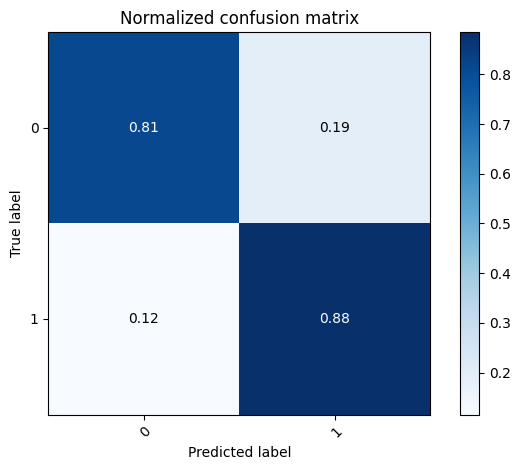

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

modelo = LogisticRegression(random_state = 42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))
preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

Para poder llegar a los resultados óptimos con este algoritmo, se tendrán que utilizar técnicas de optimización que ayuden a encontrar los mejores hiperparámetros.

Dependiendo de la regularización que se utilice ('Elasticnet' o L1 y L2 combinadas, o cada una por separado), se tendrán que optimizar unos hiperparámetros u otros. Para ello se utiliza RandomizedSearch y GridSearch.

#### Regularization elasticnet (L1 + L2)

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [0.01, 0.1, 1, 10, 100, 1000],
              "l1_ratio": randint(0,1),
              "solver": ['saga'],
              "max_iter": [250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy', verbose = 100)
result = random.fit(X = X_train, y = y_train)

result.cv_results_
print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch: ", result.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mejor accuracy para RandomizedSearchCV:  0.8451666666666666
Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch:  {'C': 100, 'l1_ratio': 0, 'max_iter': 10000, 'solver': 'saga'}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8824    0.8491    0.8654        53
           1     0.8519    0.8846    0.8679        52

    accuracy                         0.8667       105
   macro avg     0.8671    0.8668    0.8667       105
weighted avg     0.8672    0.8667    0.8666       105

Roc auc score del modelo: 0.9096516690856314


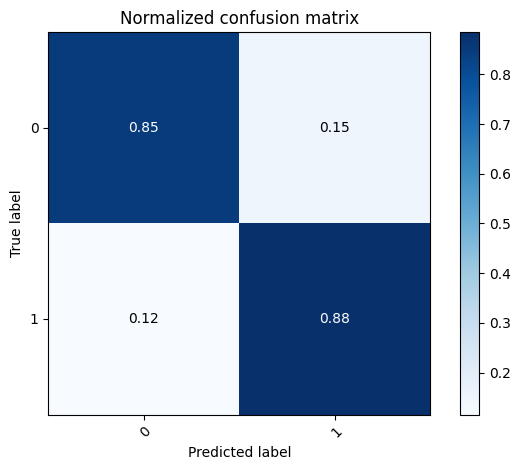

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"C": [10, 50, 100, 500, 1000],
              "l1_ratio": [0, 0.1, 0.2, 0.3],
              "solver": ['saga'],
              "max_iter": [5000, 7500, 10000, 12500, 15000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8451666666666666
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 50, 'l1_ratio': 0, 'max_iter': 5000, 'solver': 'saga'}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8824    0.8491    0.8654        53
           1     0.8519    0.8846    0.8679        52

    accuracy                         0.8667       105
   macro avg     0.8671    0.8668    0.8667       105
weighted avg     0.8672    0.8667    0.8666       105

Roc auc score del modelo: 0.9092888243831639


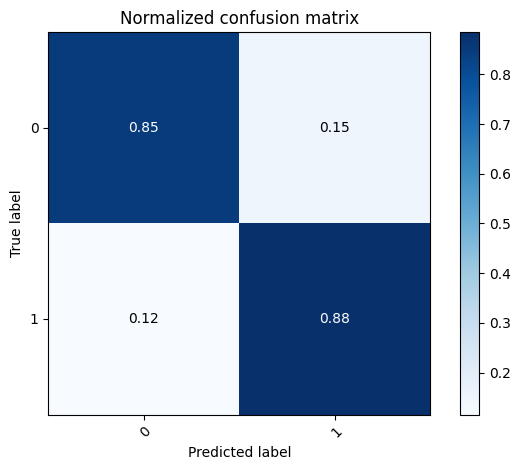

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization L1 or L2

**RandomizedSearch**

In [ ]:
param_dist = {"penalty": ['l1', 'l2'],
              "C": [0.01, 0.1, 1, 10, 100, 1000],
              "solver": ['liblinear'],
              "max_iter": [100, 250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

clf = LogisticRegression(random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor MAE para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.


Mejor MAE para RandomizedSearchCV:  0.8323333333333334
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 100}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8824    0.8491    0.8654        53
           1     0.8519    0.8846    0.8679        52

    accuracy                         0.8667       105
   macro avg     0.8671    0.8668    0.8667       105
weighted avg     0.8672    0.8667    0.8666       105

Roc auc score del modelo: 0.9085631349782292


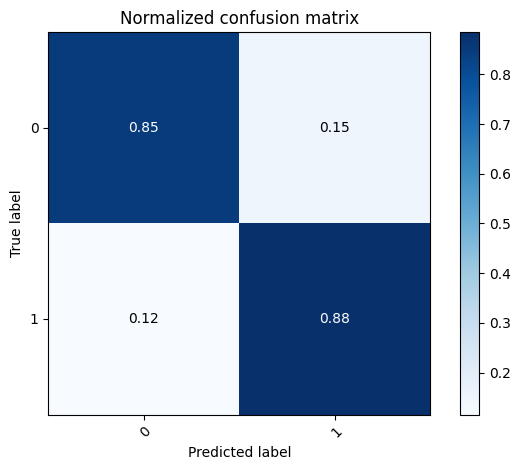

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"penalty": ['l1', 'l2'],
              "C": [50,100,150],
              "solver": ['liblinear'],
              "max_iter": [50, 100, 150, 250]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

Liblinear failed to converge, increase the number of iterations.


Mejor accuracy para GridSearchCV:  0.8451666666666666
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 50, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8824    0.8491    0.8654        53
           1     0.8519    0.8846    0.8679        52

    accuracy                         0.8667       105
   macro avg     0.8671    0.8668    0.8667       105
weighted avg     0.8672    0.8667    0.8666       105

Roc auc score del modelo: 0.9078374455732947


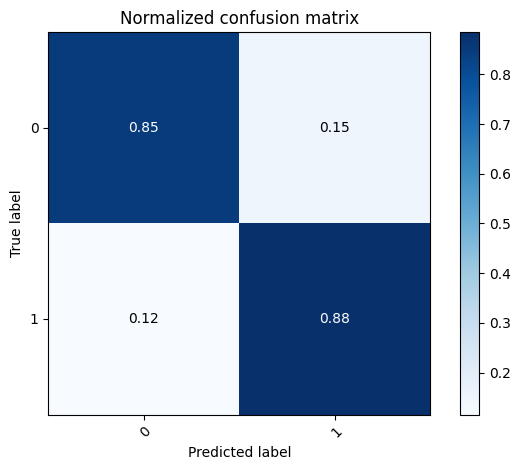

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.79245283 0.20754717]
 [0.13461538 0.86538462]]
              precision    recall  f1-score   support

           0     0.8571    0.7925    0.8235        53
           1     0.8036    0.8654    0.8333        52

    accuracy                         0.8286       105
   macro avg     0.8304    0.8289    0.8284       105
weighted avg     0.8306    0.8286    0.8284       105

Roc auc score del modelo: 0.8915094339622641


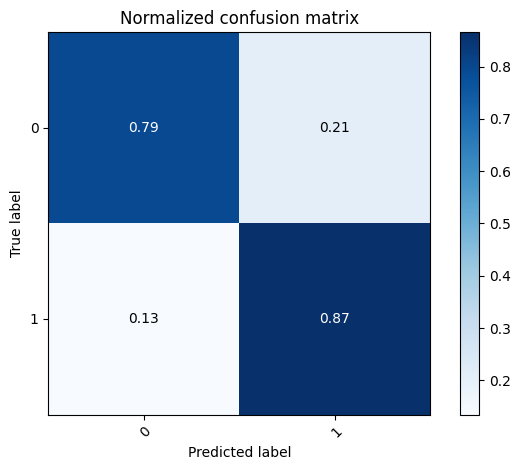

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

modelo = LogisticRegression(random_state = 42)
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))
preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization elasticnet (L1 + L2)

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [0.01, 0.1, 1, 10, 100, 1000],
              "l1_ratio": randint(0,1),
              "solver": ['saga'],
              "max_iter": [250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy', verbose = 100)
result = random.fit(X = X_train_pca, y = y_train)

result.cv_results_
print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch: ", result.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mejor accuracy para RandomizedSearchCV:  0.837
Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch:  {'C': 10, 'l1_ratio': 0, 'max_iter': 10000, 'solver': 'saga'}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8431    0.8113    0.8269        53
           1     0.8148    0.8462    0.8302        52

    accuracy                         0.8286       105
   macro avg     0.8290    0.8287    0.8286       105
weighted avg     0.8291    0.8286    0.8285       105

Roc auc score del modelo: 0.884978229317852


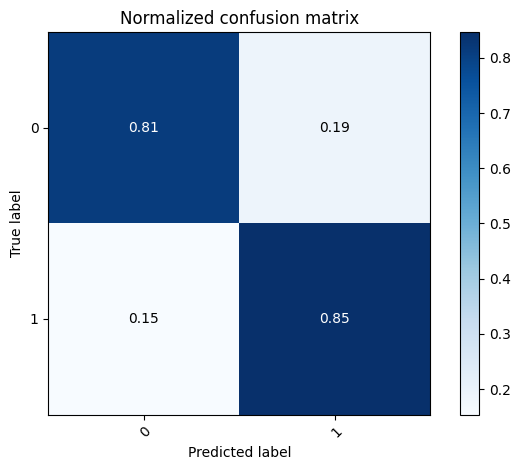

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"C": [1,10,50],
              "l1_ratio": [0, 0.1, 0.2, 0.3],
              "solver": ['saga'],
              "max_iter": [5000, 7500, 10000, 12500, 15000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.837
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 10, 'l1_ratio': 0, 'max_iter': 5000, 'solver': 'saga'}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8431    0.8113    0.8269        53
           1     0.8148    0.8462    0.8302        52

    accuracy                         0.8286       105
   macro avg     0.8290    0.8287    0.8286       105
weighted avg     0.8291    0.8286    0.8285       105

Roc auc score del modelo: 0.884978229317852


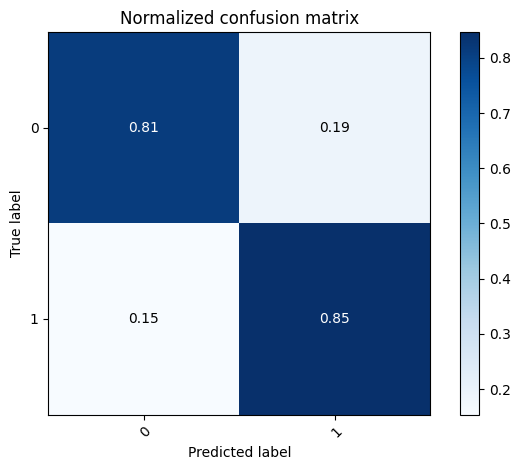

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization L1 or L2

**RandomizedSearch**

In [ ]:
param_dist = {"penalty": ['l1', 'l2'],
              "C": [0.01, 0.1, 1, 10, 100, 1000],
              "solver": ['liblinear'],
              "max_iter": [100, 250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

clf = LogisticRegression(random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor MAE para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.


Mejor MAE para RandomizedSearchCV:  0.8361666666666668
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.8269    0.8113    0.8190        53
           1     0.8113    0.8269    0.8190        52

    accuracy                         0.8190       105
   macro avg     0.8191    0.8191    0.8190       105
weighted avg     0.8192    0.8190    0.8190       105

Roc auc score del modelo: 0.8846153846153846


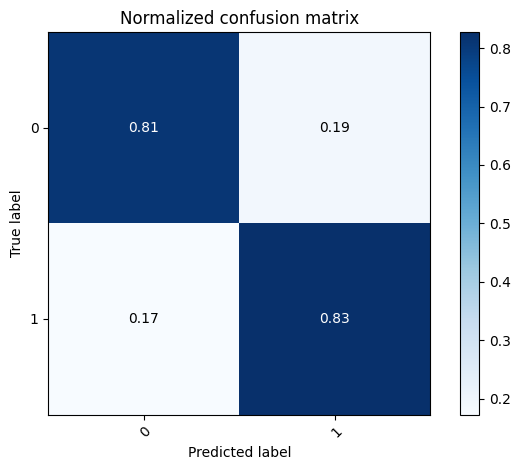

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"penalty": ['l1', 'l2'],
              "C": [1,10,50],
              "solver": ['liblinear'],
              "max_iter": [50, 100, 150, 250]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.837
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8431    0.8113    0.8269        53
           1     0.8148    0.8462    0.8302        52

    accuracy                         0.8286       105
   macro avg     0.8290    0.8287    0.8286       105
weighted avg     0.8291    0.8286    0.8285       105

Roc auc score del modelo: 0.884978229317852


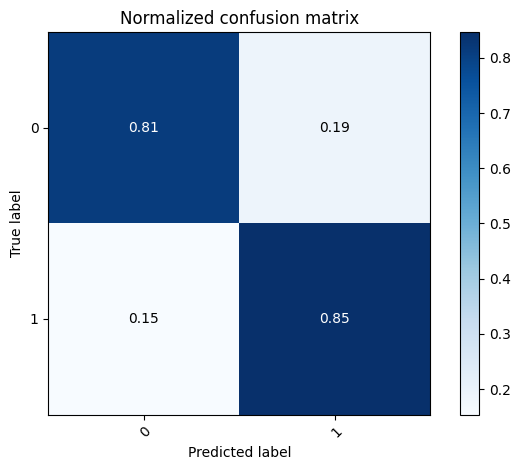

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.863933236574746


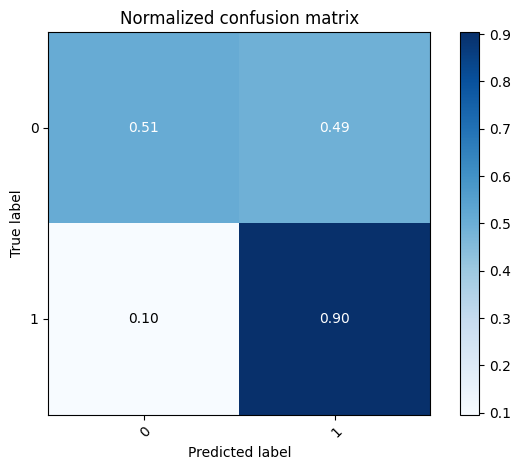

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

modelo = LogisticRegression(random_state = 42)
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))
preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization elasticnet (L1 + L2)

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [0.01, 0.1, 1, 10, 100, 1000],
              "l1_ratio": randint(0,1),
              "solver": ['saga'],
              "max_iter": [250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy', verbose = 100)
result = random.fit(X = X_train_umap, y = y_train)

result.cv_results_
print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch: ", result.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mejor accuracy para RandomizedSearchCV:  0.7259999999999999
Mejores hiperparámetros encontrados para Regresión Logística mediante RandomizedSearch:  {'C': 1, 'l1_ratio': 0, 'max_iter': 500, 'solver': 'saga'}


The max_iter was reached which means the coef_ did not converge


The max_iter was reached which means the coef_ did not converge


Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.8686502177068214


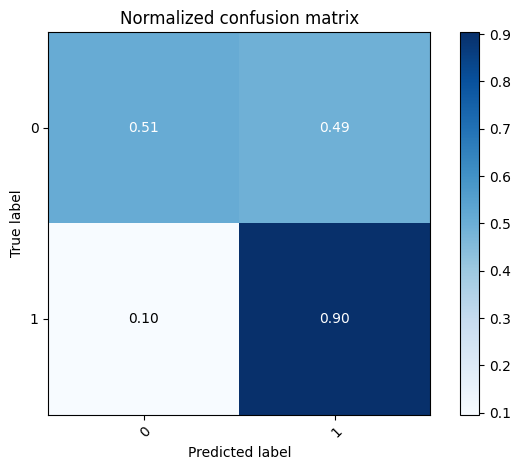

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"C": [1,2,3,4,5],
              "l1_ratio": [0, 0.1, 0.2, 0.3],
              "solver": ['saga'],
              "max_iter": [100,250,500,1000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(penalty = 'elasticnet', random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Mejor accuracy para GridSearchCV:  0.7259999999999999
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 1, 'l1_ratio': 0, 'max_iter': 100, 'solver': 'saga'}


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.867198838896952


The max_iter was reached which means the coef_ did not converge


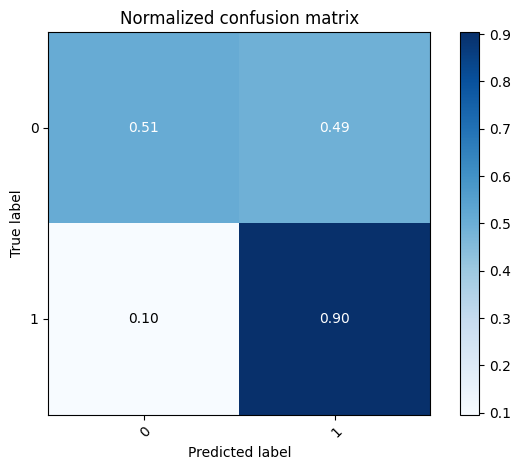

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization L1 or L2

**RandomizedSearch**

In [ ]:
param_dist = {"penalty": ['l1', 'l2'],
              "C": [0.01, 0.1, 1, 10, 100, 1000],
              "solver": ['liblinear'],
              "max_iter": [100, 250, 500, 1000, 10000]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

clf = LogisticRegression(random_state = 42)
random = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor MAE para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.


Mejor MAE para RandomizedSearchCV:  0.7255
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 0.01}


Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.853410740203193


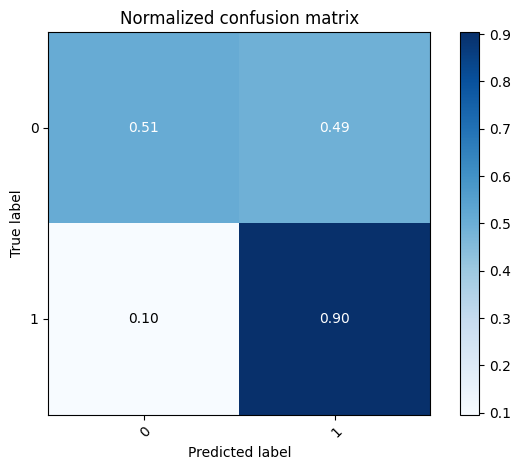

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"penalty": ['l1', 'l2'],
              "C": [0.001, 0.01, 0.1],
              "solver": ['liblinear'],
              "max_iter": [50, 100, 150, 250]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

clf = LogisticRegression(random_state = 42)
grid = GridSearchCV(estimator = clf, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.7259999999999999
Mejores hiperparámetros encontrados para Regresión Logística mediante GridSearch:  {'C': 0.001, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}


Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.8621190130624092


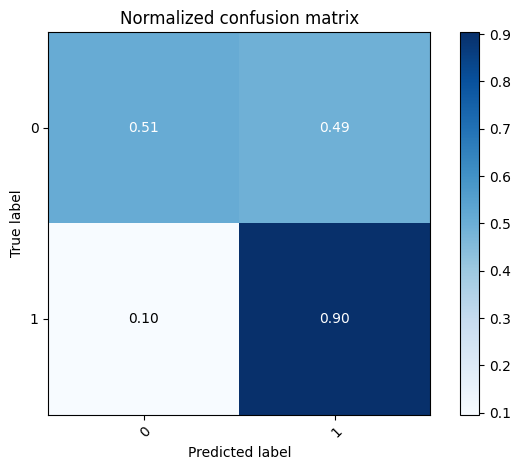

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Árboles de decisión

### Datos iniciales (sin reducción de características)

Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.34615385 0.65384615]]
              precision    recall  f1-score   support

           0     0.7143    0.8491    0.7759        53
           1     0.8095    0.6538    0.7234        52

    accuracy                         0.7524       105
   macro avg     0.7619    0.7515    0.7496       105
weighted avg     0.7615    0.7524    0.7499       105

Roc auc score del modelo: 0.7514513788098695


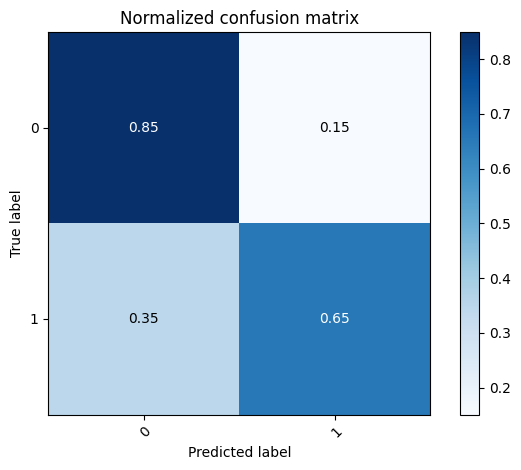

In [37]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in tree.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = tree, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8575000000000002
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 31, 'min_samples_split': 41, 'splitter': 'best'}


Normalized confusion matrix
[[0.64150943 0.35849057]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.7907    0.6415    0.7083        53
           1     0.6935    0.8269    0.7544        52

    accuracy                         0.7333       105
   macro avg     0.7421    0.7342    0.7314       105
weighted avg     0.7426    0.7333    0.7311       105

Roc auc score del modelo: 0.8071480406386067


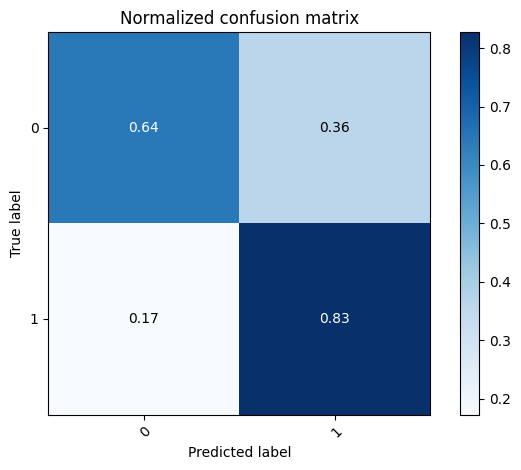

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [None,1,2,4],
              "min_samples_split": [20,31,40],
              "min_samples_leaf": [20,30,40],
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

tree = DecisionTreeClassifier(random_state = 52)
grid = GridSearchCV(estimator = tree, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8525
Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV:  {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 30, 'min_samples_split': 20, 'splitter': 'best'}


Normalized confusion matrix
[[0.64150943 0.35849057]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.7907    0.6415    0.7083        53
           1     0.6935    0.8269    0.7544        52

    accuracy                         0.7333       105
   macro avg     0.7421    0.7342    0.7314       105
weighted avg     0.7426    0.7333    0.7311       105

Roc auc score del modelo: 0.8129535558780842


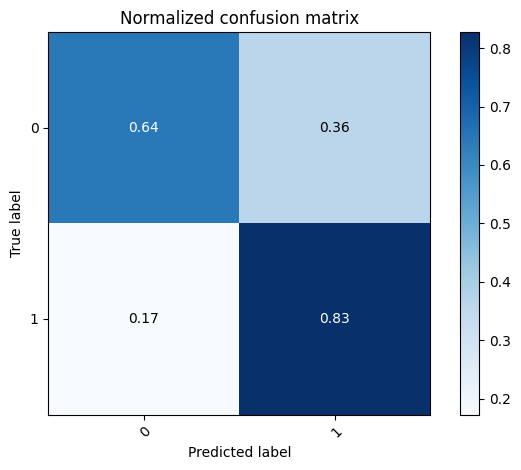

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.38461538 0.61538462]]
              precision    recall  f1-score   support

           0     0.6667    0.7547    0.7080        53
           1     0.7111    0.6154    0.6598        52

    accuracy                         0.6857       105
   macro avg     0.6889    0.6851    0.6839       105
weighted avg     0.6887    0.6857    0.6841       105

Roc auc score del modelo: 0.6850507982583455


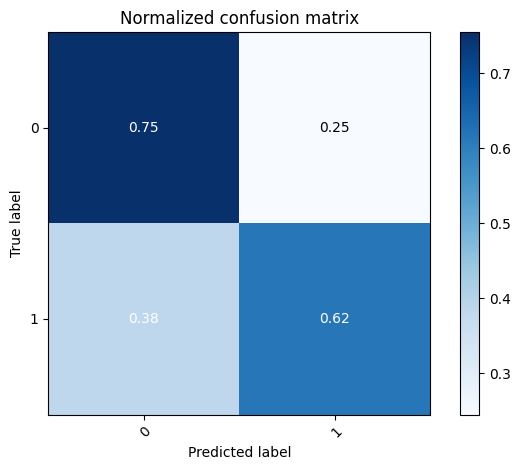

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_pca, y_train)
y_pred = tree.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in tree.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = tree, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8245000000000001
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 14, 'min_samples_split': 47, 'splitter': 'random'}


Normalized confusion matrix
[[0.60377358 0.39622642]
 [0.03846154 0.96153846]]
              precision    recall  f1-score   support

           0     0.9412    0.6038    0.7356        53
           1     0.7042    0.9615    0.8130        52

    accuracy                         0.7810       105
   macro avg     0.8227    0.7827    0.7743       105
weighted avg     0.8238    0.7810    0.7740       105

Roc auc score del modelo: 0.8510522496371553


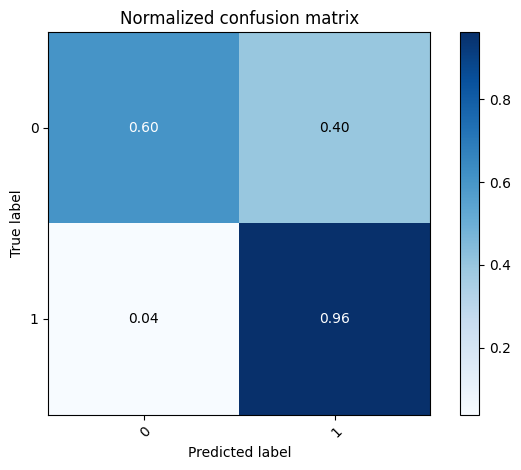

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [2,4,8,16],
              "min_samples_split": [40,47,55,60],
              "min_samples_leaf": [5,10,14,20],
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

tree = DecisionTreeClassifier(random_state = 52)
grid = GridSearchCV(estimator = tree, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8115
Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV:  {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 40, 'splitter': 'best'}


Normalized confusion matrix
[[0.64150943 0.35849057]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8095    0.6415    0.7158        53
           1     0.6984    0.8462    0.7652        52

    accuracy                         0.7429       105
   macro avg     0.7540    0.7438    0.7405       105
weighted avg     0.7545    0.7429    0.7403       105

Roc auc score del modelo: 0.8445210449927432


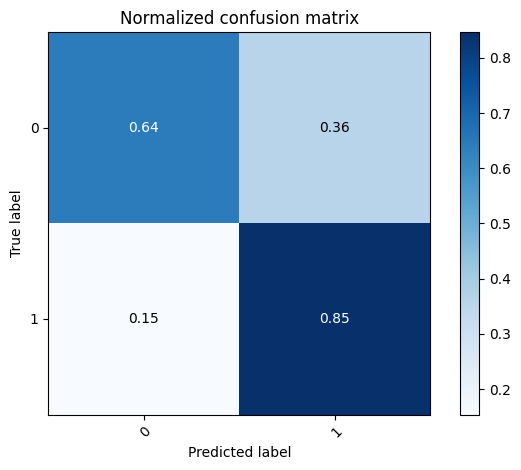

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_pca, y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8333    0.7547    0.7921        53
           1     0.7719    0.8462    0.8073        52

    accuracy                         0.8000       105
   macro avg     0.8026    0.8004    0.7997       105
weighted avg     0.8029    0.8000    0.7996       105

Roc auc score del modelo: 0.8004354136429609


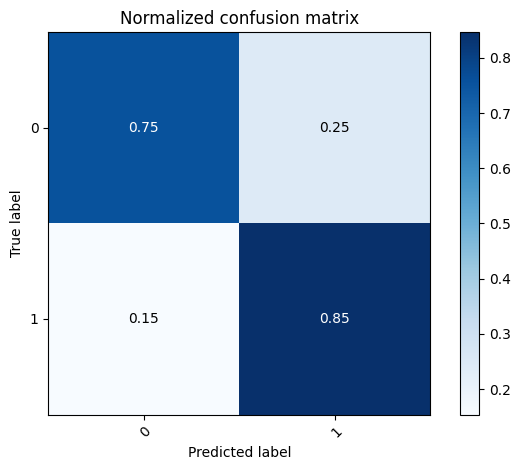

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_umap, y_train)
y_pred = tree.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in tree.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = tree, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8243333333333333
Mejores hiperparámetros encontrados para DecisionTree mediante RandomizedSearch:  {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 7, 'splitter': 'random'}


Normalized confusion matrix
[[0.56603774 0.43396226]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8571    0.5660    0.6818        53
           1     0.6714    0.9038    0.7705        52

    accuracy                         0.7333       105
   macro avg     0.7643    0.7349    0.7262       105
weighted avg     0.7652    0.7333    0.7257       105

Roc auc score del modelo: 0.8185776487663281


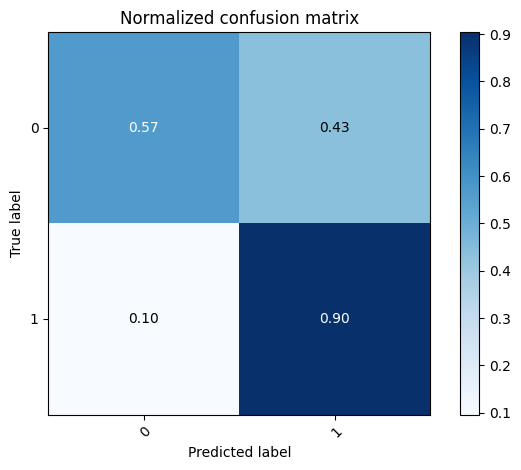

In [ ]:
modelo = random.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
param_dist = {"criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "max_depth": [4,8,12,16],
              "min_samples_split": [2,5,7,10],
              "min_samples_leaf": [1,3,5,10],
              "max_features": ['sqrt', 'log2', None]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 52)

tree = DecisionTreeClassifier(random_state = 52)
grid = GridSearchCV(estimator = tree, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8240000000000001
Mejores hiperparámetros encontrados para DecisionTree mediante GridSearchCV:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'random'}


Normalized confusion matrix
[[0.79245283 0.20754717]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.8235    0.7925    0.8077        53
           1     0.7963    0.8269    0.8113        52

    accuracy                         0.8095       105
   macro avg     0.8099    0.8097    0.8095       105
weighted avg     0.8100    0.8095    0.8095       105

Roc auc score del modelo: 0.8717343976777939


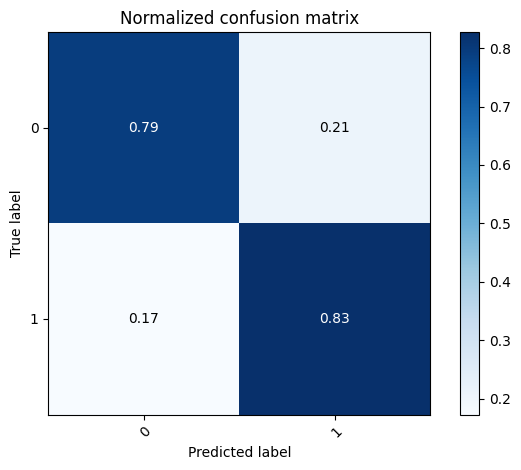

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X_train_umap, y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Support Vector Machine (SVM)

### Datos iniciales (sin reducción de características)

Se quiere ver lo primero si los datos son linealmente separables. Para eso se van a graficar utilizando el algoritmo de t - SNE

        TSNE1      TSNE2  TYPE
0    2.552699  13.083561     0
1   -6.268142 -28.555336     0
2    3.051491  17.179268     0
3   -5.817848 -32.130733     0
4   -6.831447  -1.414468     0
..        ...        ...   ...
344  1.101350  22.438629     1
345 -5.305102  18.030251     1
346  7.199683 -25.224125     1
347  2.254823  22.598074     1
348  6.641284  12.363390     1

[349 rows x 3 columns]


<Axes: xlabel='TSNE1', ylabel='TSNE2'>

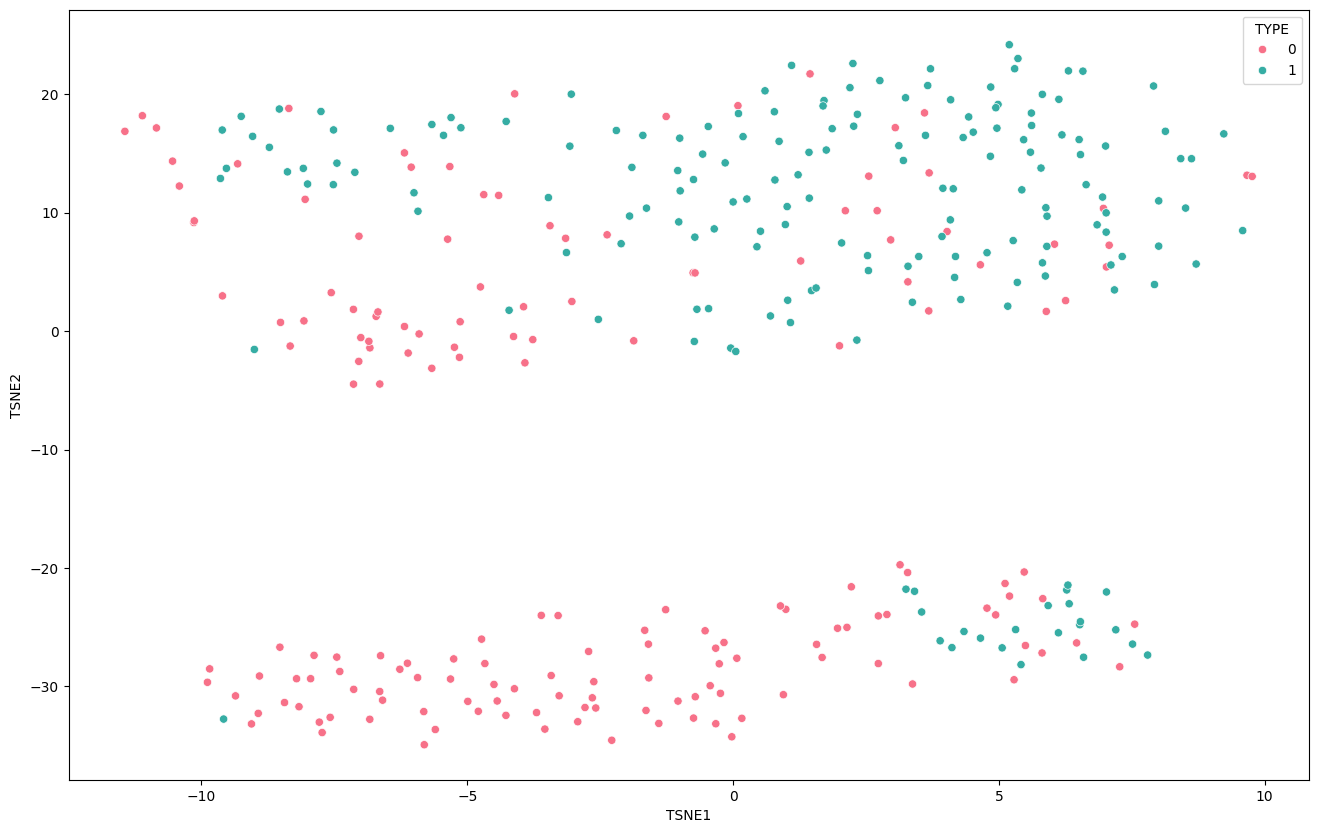

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=0)
tsne_vis = tsne.fit_transform(x_cancer_data)
tsne_vis = pd.DataFrame(data = tsne_vis, columns = ['TSNE1', 'TSNE2'])
tsne_all = pd.concat([tsne_vis, y_cancer_data], axis = 1)
print(tsne_all)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x= 'TSNE1',
    y= 'TSNE2',
    hue = 'TYPE',
    palette=sns.color_palette("husl", 2),
    data= tsne_all,
    legend="full"
)

Nos encontramos con que no son linealmente separables, por lo que no tendrá sentido pensar en un modelo SVM con kernel lineal.

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9318    0.7736    0.8454        53
           1     0.8033    0.9423    0.8673        52

    accuracy                         0.8571       105
   macro avg     0.8675    0.8579    0.8563       105
weighted avg     0.8682    0.8571    0.8562       105

Roc auc score del modelo: 0.9031204644412192


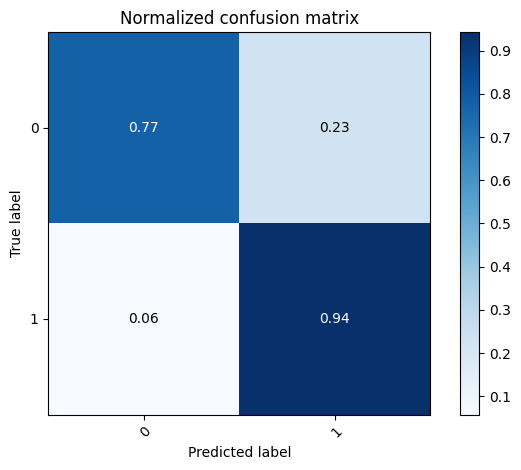

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 42, probability=True) #Aquí el kernel por defecto es 'rbf'
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svm.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": randint(1,50),
              "kernel": ['poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": randint(1,10)}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
random = RandomizedSearchCV(estimator = svm, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.845
Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch:  {'C': 3, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9348    0.8113    0.8687        53
           1     0.8305    0.9423    0.8829        52

    accuracy                         0.8762       105
   macro avg     0.8826    0.8768    0.8758       105
weighted avg     0.8831    0.8762    0.8757       105

Roc auc score del modelo: 0.9027576197387518


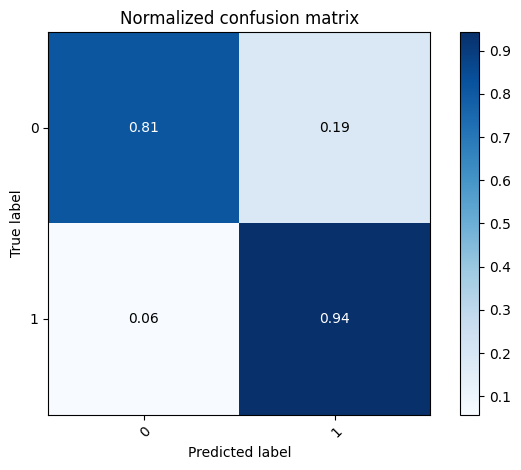

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [1,3,5,7],
              "kernel": ['poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": [1,2,3,4]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
grid = GridSearchCV(estimator = svm, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.845
Mejores hiperparámetros encontrados para SVM mediante GridSearchCV:  {'C': 3, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9348    0.8113    0.8687        53
           1     0.8305    0.9423    0.8829        52

    accuracy                         0.8762       105
   macro avg     0.8826    0.8768    0.8758       105
weighted avg     0.8831    0.8762    0.8757       105

Roc auc score del modelo: 0.9027576197387518


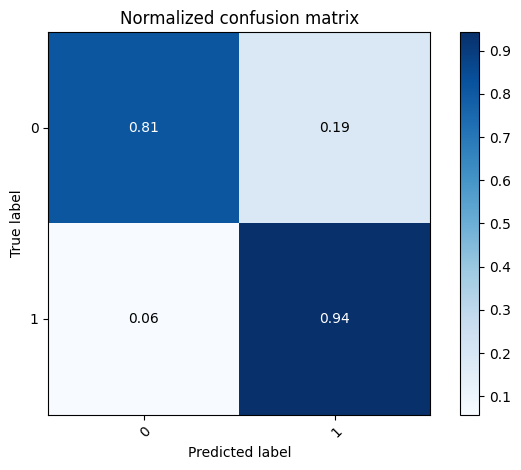

In [ ]:
svc = grid.best_estimator_
svc.fit(X = X_train, y = y_train)
y_pred = svc.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svc.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

Debido a que ha sido el modelo elegido tras hacer la comparación de resultados con los demás modelos, se van a tratar de optimizar más aún los resultados del algoritmo de SVM utilizando distinta cuadrícula de parámetros, con el objetivo de minimizar la tasa de falsos negativos.

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": randint(1,200),
              "kernel": ['poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": randint(1,10),
              "coef0": randint(0,10),
              "tol": [1e-2, 1e-3, 1e-4, 1e-5]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
random = RandomizedSearchCV(estimator = svm, param_distributions = param_dist, n_iter = 200, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8445
Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch:  {'C': 7, 'coef0': 9, 'degree': 6, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.01}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9348    0.8113    0.8687        53
           1     0.8305    0.9423    0.8829        52

    accuracy                         0.8762       105
   macro avg     0.8826    0.8768    0.8758       105
weighted avg     0.8831    0.8762    0.8757       105

Roc auc score del modelo: 0.9132801161103048


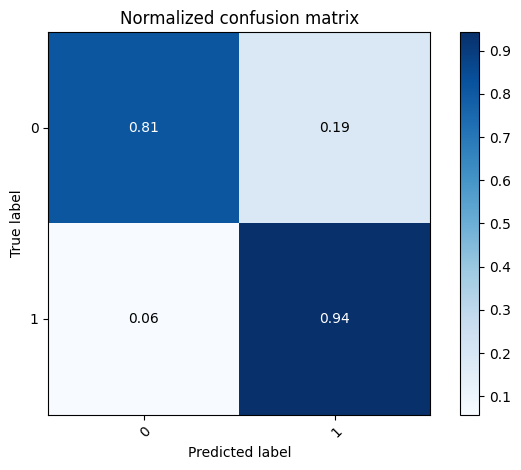

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [3,5,7,9,11],
              "kernel": ['poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": [4,5,6,7,8],
              "coef0": [6,9,12,15],
              "tol": [0, 1e-1,1e-2,1e-3]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
grid = GridSearchCV(estimator = svm, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante GridSearchCV: ", result.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6000 fits failed out of a total of 24000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Mejor accuracy para GridSearchCV:  0.845
Mejores hiperparámetros encontrados para SVM mediante GridSearchCV:  {'C': 3, 'coef0': 6, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [   nan 0.787  0.787  ... 0.4805 0.4805 0.4805]
  warnings.warn(


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9348    0.8113    0.8687        53
           1     0.8305    0.9423    0.8829        52

    accuracy                         0.8762       105
   macro avg     0.8826    0.8768    0.8758       105
weighted avg     0.8831    0.8762    0.8757       105

Roc auc score del modelo: 0.9027576197387518


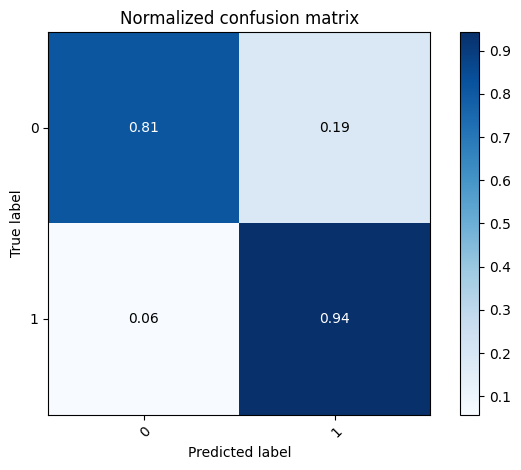

In [ ]:
svc = grid.best_estimator_
svc.fit(X = X_train, y = y_train)
y_pred = svc.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svc.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9091    0.7547    0.8247        53
           1     0.7869    0.9231    0.8496        52

    accuracy                         0.8381       105
   macro avg     0.8480    0.8389    0.8371       105
weighted avg     0.8486    0.8381    0.8370       105

Roc auc score del modelo: 0.8831640058055152


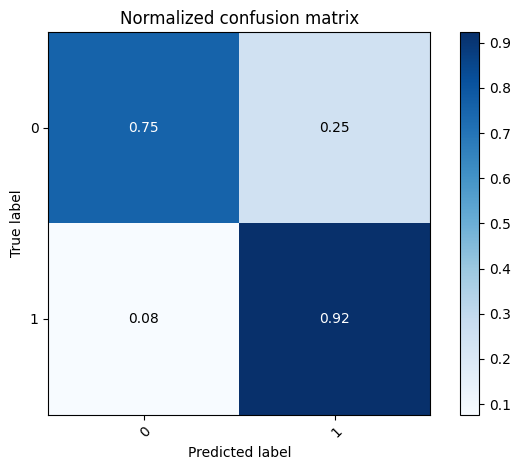

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 42, probability=True)
svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svm.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
param_dist = {"C": randint(1,20),
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": randint(1,5)}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
random = RandomizedSearchCV(estimator = svm, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8651666666666668
Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch:  {'C': 3, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9111    0.7736    0.8367        53
           1     0.8000    0.9231    0.8571        52

    accuracy                         0.8476       105
   macro avg     0.8556    0.8483    0.8469       105
weighted avg     0.8561    0.8476    0.8468       105

Roc auc score del modelo: 0.8824383164005806


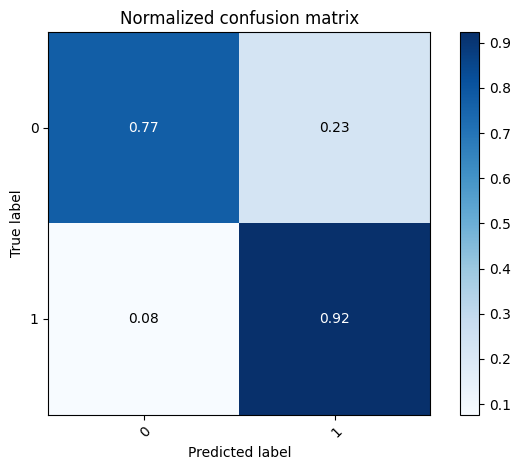

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [1,3,5,10],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": [1,2,3]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
grid = GridSearchCV(estimator = svm, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8651666666666668
Mejores hiperparámetros encontrados para SVM mediante GridSearchCV:  {'C': 3, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9111    0.7736    0.8367        53
           1     0.8000    0.9231    0.8571        52

    accuracy                         0.8476       105
   macro avg     0.8556    0.8483    0.8469       105
weighted avg     0.8561    0.8476    0.8468       105

Roc auc score del modelo: 0.8824383164005806


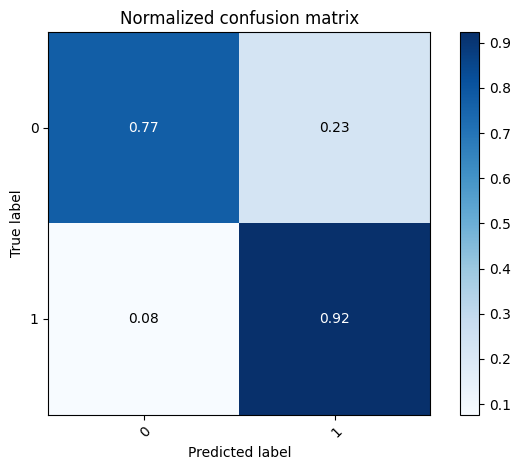

In [ ]:
svc = grid.best_estimator_
svc.fit(X = X_train_pca, y = y_train)
y_pred = svc.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svc.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.50943396 0.49056604]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8438    0.5094    0.6353        53
           1     0.6438    0.9038    0.7520        52

    accuracy                         0.7048       105
   macro avg     0.7438    0.7066    0.6936       105
weighted avg     0.7447    0.7048    0.6931       105

Roc auc score del modelo: 0.861756168359942


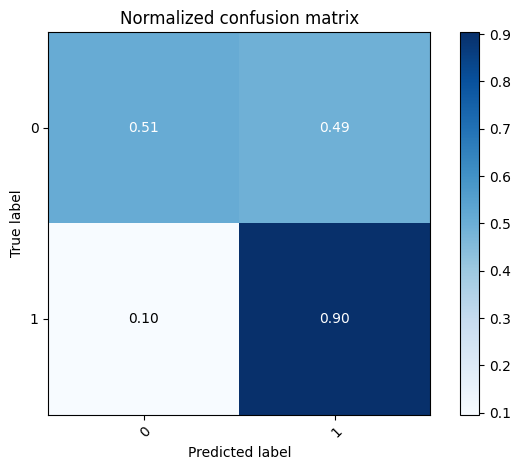

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 42, probability=True)
svm.fit(X_train_umap, y_train)
y_pred = svm.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svm.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
param_dist = {"C": randint(1,20),
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": randint(1,5)}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
random = RandomizedSearchCV(estimator = svm, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8208333333333334
Mejores hiperparámetros encontrados para SVM mediante RandomizedSearch:  {'C': 6, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.67924528 0.32075472]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9000    0.6792    0.7742        53
           1     0.7385    0.9231    0.8205        52

    accuracy                         0.8000       105
   macro avg     0.8192    0.8012    0.7974       105
weighted avg     0.8200    0.8000    0.7971       105

Roc auc score del modelo: 0.8686502177068215


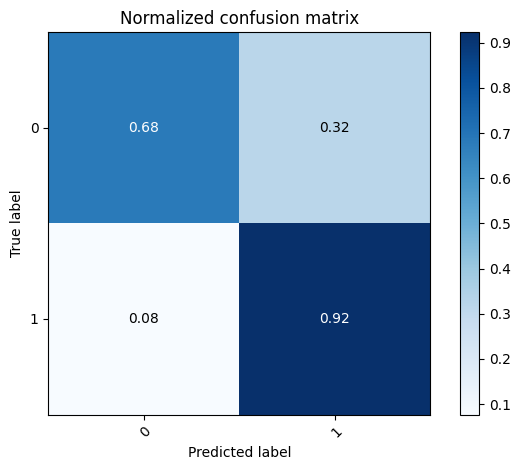

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

param_dist = {"C": [4,6,10,12],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "gamma": ['scale', 'auto'],
              "degree": [1,2,3]}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

svm = SVC(random_state = 42, probability=True)
grid = GridSearchCV(estimator = svm, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para SVM mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8208333333333334
Mejores hiperparámetros encontrados para SVM mediante GridSearchCV:  {'C': 6, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}


Normalized confusion matrix
[[0.67924528 0.32075472]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9000    0.6792    0.7742        53
           1     0.7385    0.9231    0.8205        52

    accuracy                         0.8000       105
   macro avg     0.8192    0.8012    0.7974       105
weighted avg     0.8200    0.8000    0.7971       105

Roc auc score del modelo: 0.8686502177068215


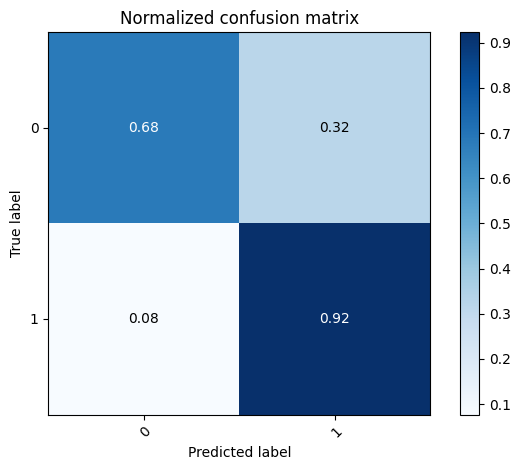

In [ ]:
svc = grid.best_estimator_
svc.fit(X = X_train_umap, y = y_train)
y_pred = svc.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svc.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Random Forest

### Datos iniciales (sin reducción de características)

Normalized confusion matrix
[[0.86792453 0.13207547]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8519    0.8679    0.8598        53
           1     0.8627    0.8462    0.8544        52

    accuracy                         0.8571       105
   macro avg     0.8573    0.8570    0.8571       105
weighted avg     0.8572    0.8571    0.8571       105

Roc auc score del modelo: 0.9350507982583454


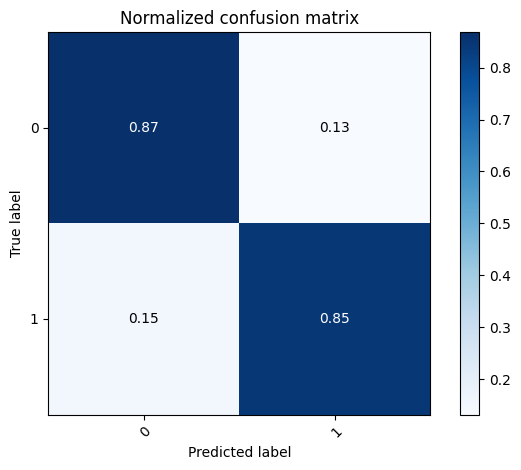

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
forest.fit(X = X_train, y = y_train)
y_pred = forest.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in forest.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "bootstrap": [True, False],
              "criterion": ['gini', 'entropy', 'log_loss']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

forest = RandomForestClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = forest, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8856666666666666
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 23, 'min_samples_split': 44, 'n_estimators': 32}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9184    0.8491    0.8824        53
           1     0.8571    0.9231    0.8889        52

    accuracy                         0.8857       105
   macro avg     0.8878    0.8861    0.8856       105
weighted avg     0.8880    0.8857    0.8856       105

Roc auc score del modelo: 0.9252539912917271


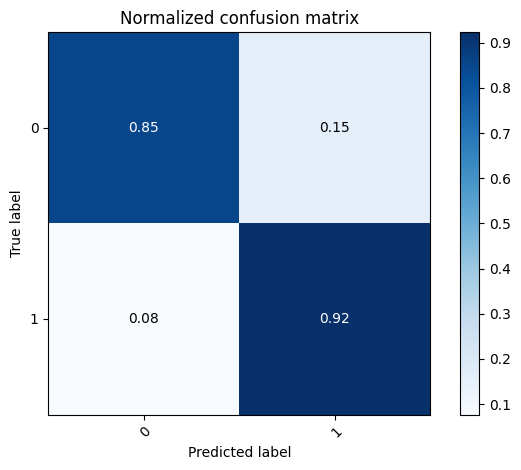

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dist = {"n_estimators": [16,32,64],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [10,12,16],
              "min_samples_split": [40,44,55],
              "min_samples_leaf": [15,23,30],
              "bootstrap": [True],
              "criterion": ['gini', 'entropy', 'log_loss']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)
forest = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(estimator = forest, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8856666666666666
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 23, 'min_samples_split': 40, 'n_estimators': 32}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9184    0.8491    0.8824        53
           1     0.8571    0.9231    0.8889        52

    accuracy                         0.8857       105
   macro avg     0.8878    0.8861    0.8856       105
weighted avg     0.8880    0.8857    0.8856       105

Roc auc score del modelo: 0.9252539912917271


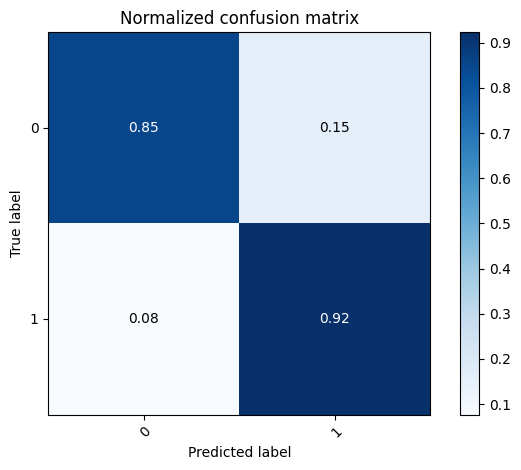

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8367    0.7736    0.8039        53
           1     0.7857    0.8462    0.8148        52

    accuracy                         0.8095       105
   macro avg     0.8112    0.8099    0.8094       105
weighted avg     0.8115    0.8095    0.8093       105

Roc auc score del modelo: 0.8657474600870827


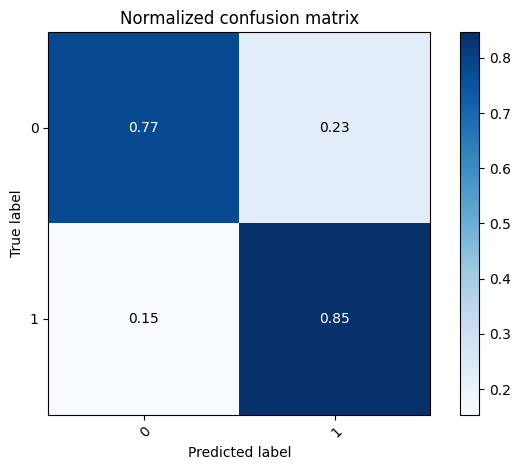

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
forest.fit(X = X_train_pca, y = y_train)
y_pred = forest.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in forest.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "bootstrap": [True, False],
              "criterion": ['gini', 'entropy', 'log_loss']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

forest = RandomForestClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = forest, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8326666666666667
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 46, 'n_estimators': 16}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.19230769 0.80769231]]
              precision    recall  f1-score   support

           0     0.8113    0.8113    0.8113        53
           1     0.8077    0.8077    0.8077        52

    accuracy                         0.8095       105
   macro avg     0.8095    0.8095    0.8095       105
weighted avg     0.8095    0.8095    0.8095       105

Roc auc score del modelo: 0.8925979680696662


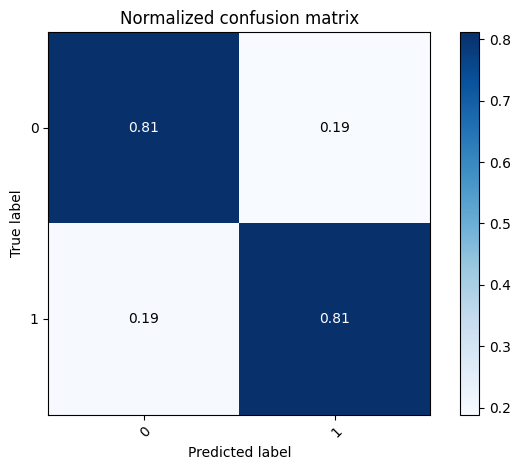

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dist = {"n_estimators": [4,8,16,32,64],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [5,10,12,16,20],
              "min_samples_split": [40,46,55,60],
              "min_samples_leaf": [1,3,8,15],
              "bootstrap": [True],
              "criterion": ['gini', 'entropy', 'log_loss']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)
forest = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(estimator = forest, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8403333333333334
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 40, 'n_estimators': 16}


Normalized confusion matrix
[[0.71698113 0.28301887]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8261    0.7170    0.7677        53
           1     0.7458    0.8462    0.7928        52

    accuracy                         0.7810       105
   macro avg     0.7859    0.7816    0.7802       105
weighted avg     0.7863    0.7810    0.7801       105

Roc auc score del modelo: 0.8592162554426706


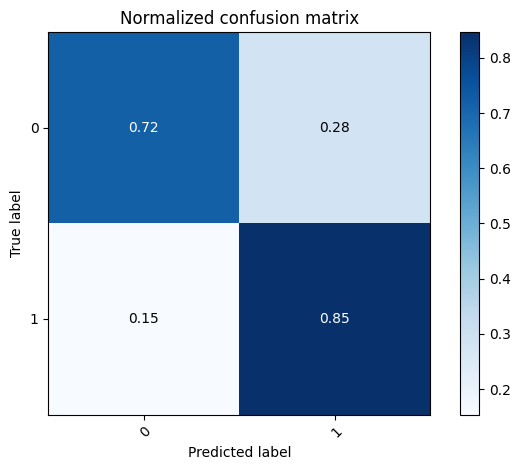

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.73584906 0.26415094]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.8125    0.7358    0.7723        53
           1     0.7544    0.8269    0.7890        52

    accuracy                         0.7810       105
   macro avg     0.7834    0.7814    0.7806       105
weighted avg     0.7837    0.7810    0.7806       105

Roc auc score del modelo: 0.8452467343976778


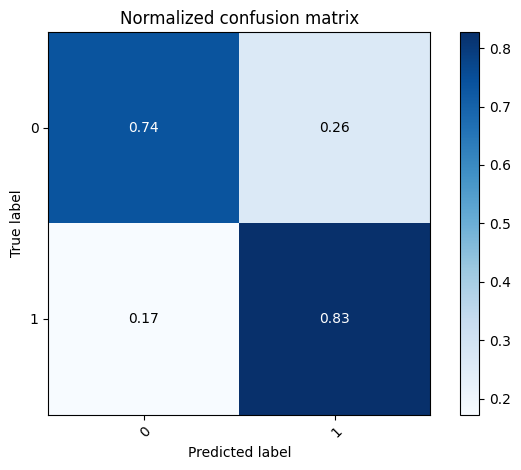

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
forest.fit(X = X_train_umap, y = y_train)
y_pred = forest.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in forest.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "bootstrap": [True, False],
              "criterion": ['gini', 'entropy', 'log_loss']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

forest = RandomForestClassifier(random_state = 42)
random = RandomizedSearchCV(estimator = forest, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8163333333333334
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 4}


Normalized confusion matrix
[[0.66037736 0.33962264]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.8974    0.6604    0.7609        53
           1     0.7273    0.9231    0.8136        52

    accuracy                         0.7905       105
   macro avg     0.8124    0.7917    0.7872       105
weighted avg     0.8132    0.7905    0.7870       105

Roc auc score del modelo: 0.8497822931785196


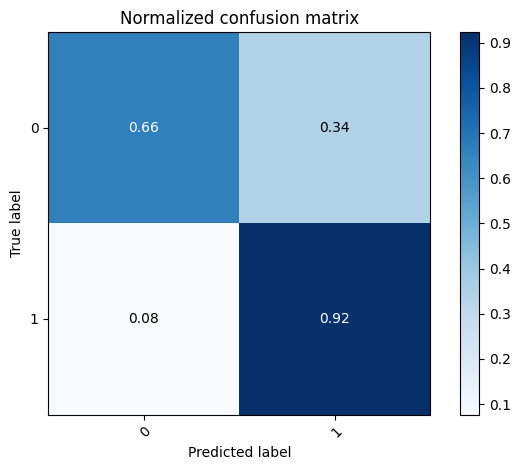

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dist = {"n_estimators": [2,4,8,16],
              "max_features": [1.0, 'sqrt'],
              "max_depth": [2,4,8,16],
              "min_samples_split": [2,3,4,5],
              "min_samples_leaf": [1,3,5,10],
              "bootstrap": [True],
              "criterion": ['gini', 'entropy', 'log_loss']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)
forest = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(estimator = forest, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8324999999999999
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 8}


Normalized confusion matrix
[[0.67924528 0.32075472]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9000    0.6792    0.7742        53
           1     0.7385    0.9231    0.8205        52

    accuracy                         0.8000       105
   macro avg     0.8192    0.8012    0.7974       105
weighted avg     0.8200    0.8000    0.7971       105

Roc auc score del modelo: 0.8701015965166908


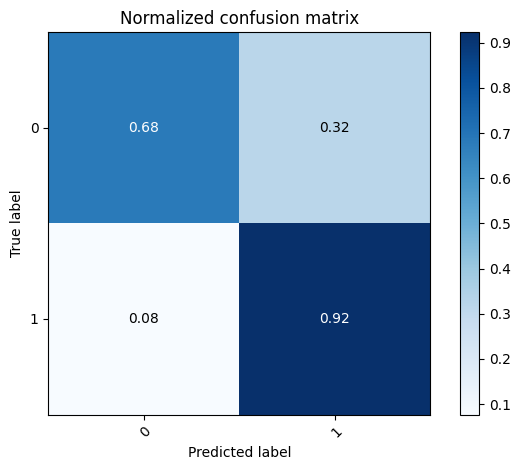

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Adaboost

El algoritmo de Adaboost utilizará el modelo de árboles de decisión proporcionado como óptimo más arriba.

### Datos iniciales (sin reducción de características)

Normalized confusion matrix
[[0.83018868 0.16981132]
 [0.26923077 0.73076923]]
              precision    recall  f1-score   support

           0     0.7586    0.8302    0.7928        53
           1     0.8085    0.7308    0.7677        52

    accuracy                         0.7810       105
   macro avg     0.7836    0.7805    0.7802       105
weighted avg     0.7833    0.7810    0.7804       105

Roc auc score del modelo: 0.8853410740203194


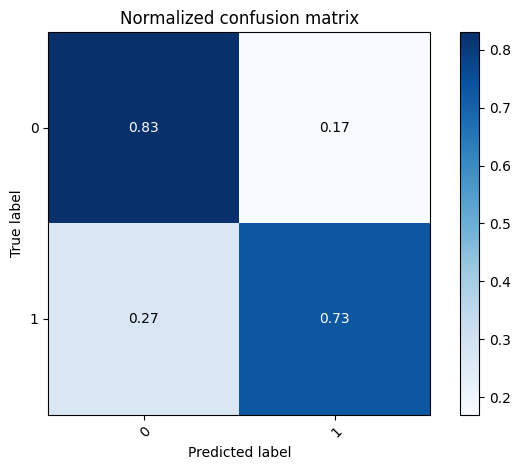

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)

ada.fit(X = X_train, y = y_train)
y_pred = ada.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "learning_rate": randint(0, 5),
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
random = RandomizedSearchCV(estimator = ada, param_distributions = param_dist, n_iter = 200, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8815
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 32}



350 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParam

Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8824    0.8491    0.8654        53
           1     0.8519    0.8846    0.8679        52

    accuracy                         0.8667       105
   macro avg     0.8671    0.8668    0.8667       105
weighted avg     0.8672    0.8667    0.8666       105

Roc auc score del modelo: 0.9303338171262701


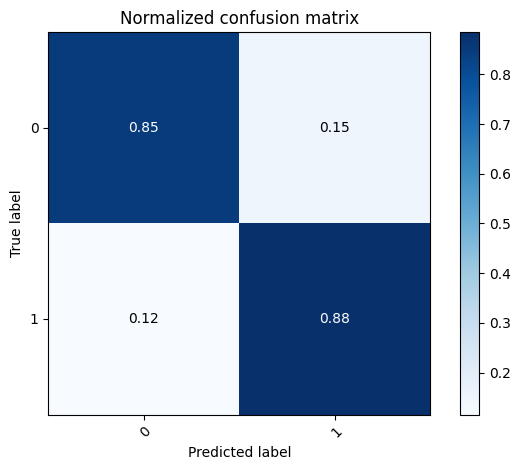

In [39]:
ada = random.best_estimator_
ada.fit(X = X_train, y = y_train)
y_pred = ada.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [16,32,64,128],
              "learning_rate": [1,2,3,5],
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, max_features = 'sqrt', min_samples_leaf = 5, min_samples_split = 15, splitter = 'best', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
grid = GridSearchCV(estimator = ada, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8855000000000001
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 128}


Normalized confusion matrix
[[0.88679245 0.11320755]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.8393    0.8868    0.8624        53
           1     0.8776    0.8269    0.8515        52

    accuracy                         0.8571       105
   macro avg     0.8584    0.8569    0.8569       105
weighted avg     0.8582    0.8571    0.8570       105

Roc auc score del modelo: 0.9158200290275762


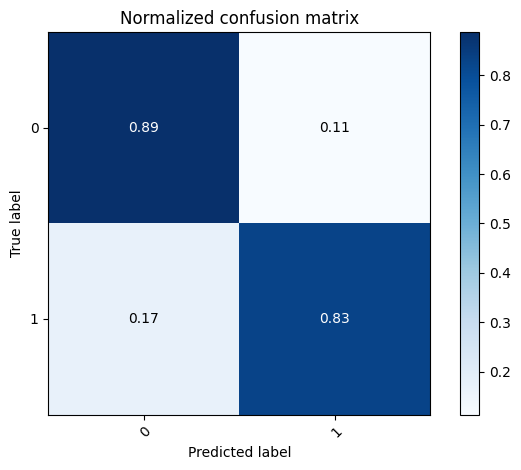

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8889    0.7547    0.8163        53
           1     0.7833    0.9038    0.8393        52

    accuracy                         0.8286       105
   macro avg     0.8361    0.8293    0.8278       105
weighted avg     0.8366    0.8286    0.8277       105

Roc auc score del modelo: 0.854499274310595


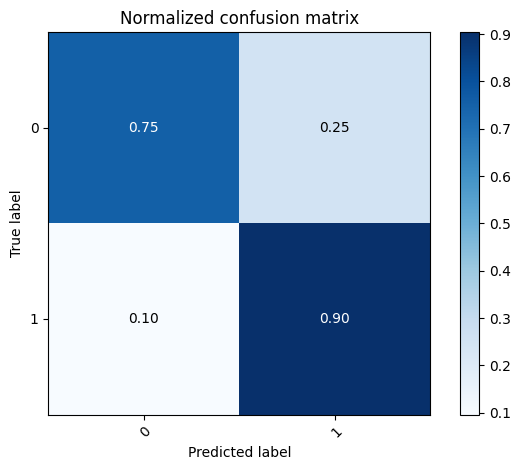

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 14, min_samples_split = 47, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)

ada.fit(X = X_train_pca, y = y_train)
y_pred = ada.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "learning_rate": randint(0,10),
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

#Se realiza Adaboost con un árbol de decisión
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 14, min_samples_split = 47, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
random = RandomizedSearchCV(estimator = ada, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.833
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'algorithm': 'SAMME.R', 'learning_rate': 6, 'n_estimators': 128}



100 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParam

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.21153846 0.78846154]]
              precision    recall  f1-score   support

           0     0.7963    0.8113    0.8037        53
           1     0.8039    0.7885    0.7961        52

    accuracy                         0.8000       105
   macro avg     0.8001    0.7999    0.7999       105
weighted avg     0.8001    0.8000    0.8000       105

Roc auc score del modelo: 0.8864296081277214


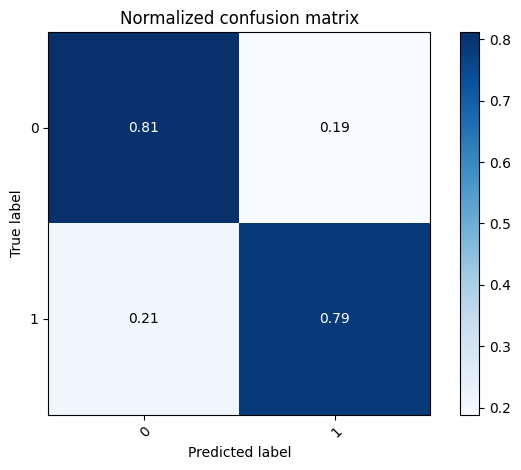

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [64,128,256],
              "learning_rate": [3,5,6,8,10],
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 14, min_samples_split = 47, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
grid = GridSearchCV(estimator = ada, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.833
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'algorithm': 'SAMME.R', 'learning_rate': 6, 'n_estimators': 128}


Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.21153846 0.78846154]]
              precision    recall  f1-score   support

           0     0.7963    0.8113    0.8037        53
           1     0.8039    0.7885    0.7961        52

    accuracy                         0.8000       105
   macro avg     0.8001    0.7999    0.7999       105
weighted avg     0.8001    0.8000    0.8000       105

Roc auc score del modelo: 0.8864296081277214


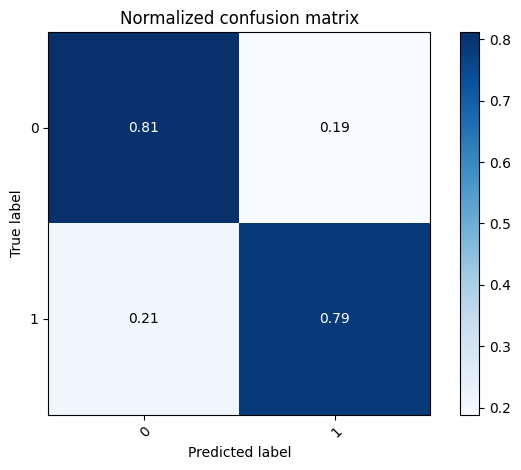

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8723    0.7736    0.8200        53
           1     0.7931    0.8846    0.8364        52

    accuracy                         0.8286       105
   macro avg     0.8327    0.8291    0.8282       105
weighted avg     0.8331    0.8286    0.8281       105

Roc auc score del modelo: 0.8561320754716981


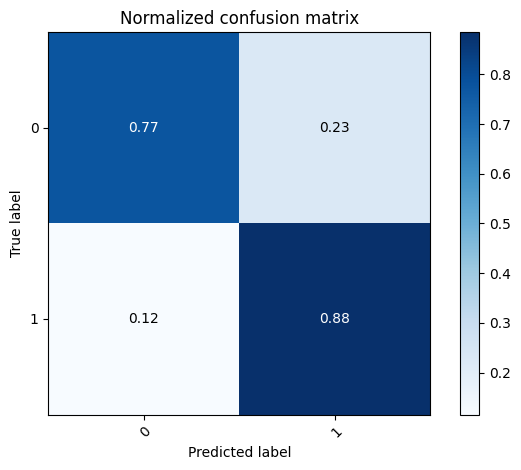

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 1, min_samples_split = 7, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)

ada.fit(X = X_train_umap, y = y_train)
y_pred = ada.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128],
              "learning_rate": randint(0,10),
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

#Se realiza Adaboost con un árbol de decisión
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 1, min_samples_split = 7, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
random = RandomizedSearchCV(estimator = ada, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8285
Mejores hiperparámetros encontrados para RandomForest mediante RandomizedSearch:  {'algorithm': 'SAMME', 'learning_rate': 6, 'n_estimators': 32}



100 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParam

Normalized confusion matrix
[[0.79245283 0.20754717]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8400    0.7925    0.8155        53
           1     0.8000    0.8462    0.8224        52

    accuracy                         0.8190       105
   macro avg     0.8200    0.8193    0.8190       105
weighted avg     0.8202    0.8190    0.8189       105

Roc auc score del modelo: 0.8595791001451378


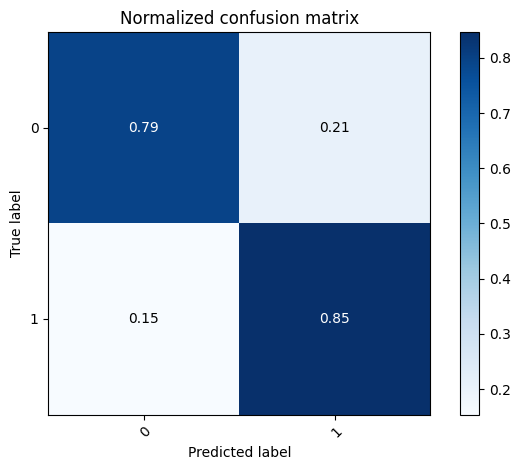

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [8,16,32,64],
              "learning_rate": [3,5,6,8,10],
              "algorithm": ['SAMME', 'SAMME.R']}

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = None, min_samples_leaf = 1, min_samples_split = 7, splitter = 'random', random_state = 42)
ada = AdaBoostClassifier(estimator = tree, random_state = 42)
grid = GridSearchCV(estimator = ada, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8285
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'algorithm': 'SAMME', 'learning_rate': 6, 'n_estimators': 32}


Normalized confusion matrix
[[0.79245283 0.20754717]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8400    0.7925    0.8155        53
           1     0.8000    0.8462    0.8224        52

    accuracy                         0.8190       105
   macro avg     0.8200    0.8193    0.8190       105
weighted avg     0.8202    0.8190    0.8189       105

Roc auc score del modelo: 0.8595791001451378


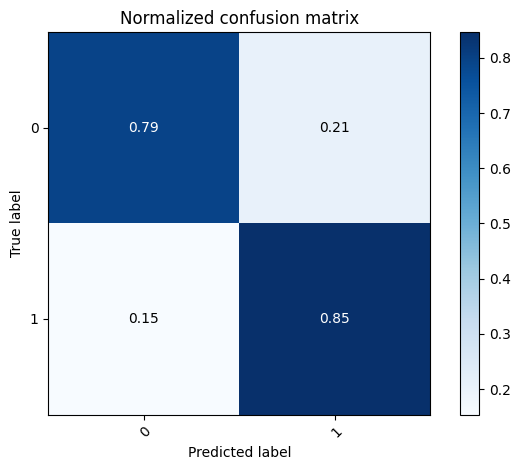

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Gradient Boosting

### Datos iniciales (sin reducción de características)

Normalized confusion matrix
[[0.83018868 0.16981132]
 [0.17307692 0.82692308]]
              precision    recall  f1-score   support

           0     0.8302    0.8302    0.8302        53
           1     0.8269    0.8269    0.8269        52

    accuracy                         0.8286       105
   macro avg     0.8286    0.8286    0.8286       105
weighted avg     0.8286    0.8286    0.8286       105

Roc auc score del modelo: 0.9245283018867925


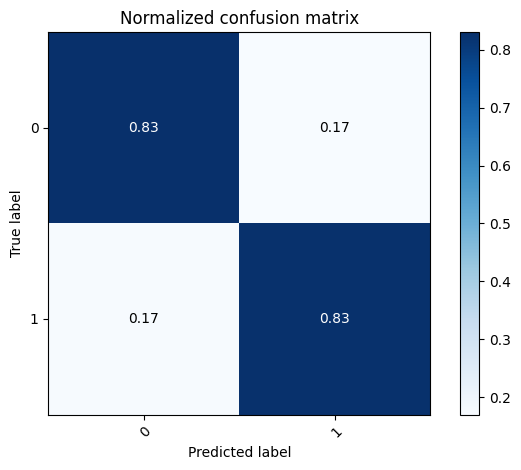

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X = X_train, y = y_train)
y_pred = gboost.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in gboost.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_dist = {"n_estimators": [10,50,100,150,200],
              "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              "criterion": ['friedman_mse', 'squared_error'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None],
              "loss": ['log_loss', 'exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
random = RandomizedSearchCV(estimator = gboost, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.9023333333333333
Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch:  {'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'exponential', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 31, 'n_estimators': 50}


Normalized confusion matrix
[[0.86792453 0.13207547]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8519    0.8679    0.8598        53
           1     0.8627    0.8462    0.8544        52

    accuracy                         0.8571       105
   macro avg     0.8573    0.8570    0.8571       105
weighted avg     0.8572    0.8571    0.8571       105

Roc auc score del modelo: 0.9401306240928884


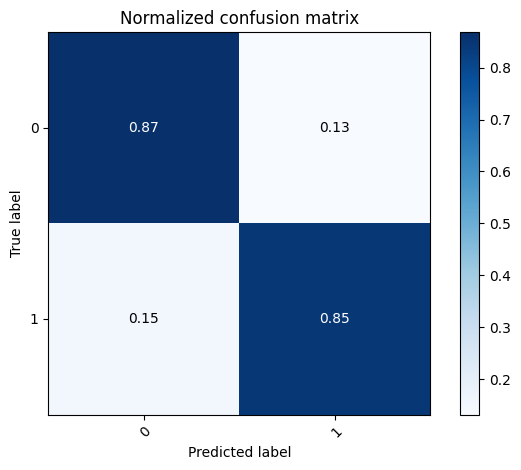

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [25,50,75],
              "learning_rate": [0.2, 0.25, 0.3],
              "criterion": ['friedman_mse'],
              "max_depth": [None,1,2],
              "min_samples_split": [25,31,40],
              "min_samples_leaf": [10,16,25],
              "max_features": ['sqrt', 'log2', None],
              "loss": ['exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(estimator = gboost, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.906
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'loss': 'exponential', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 75}


Normalized confusion matrix
[[0.8490566  0.1509434 ]
 [0.19230769 0.80769231]]
              precision    recall  f1-score   support

           0     0.8182    0.8491    0.8333        53
           1     0.8400    0.8077    0.8235        52

    accuracy                         0.8286       105
   macro avg     0.8291    0.8284    0.8284       105
weighted avg     0.8290    0.8286    0.8285       105

Roc auc score del modelo: 0.9147314949201741


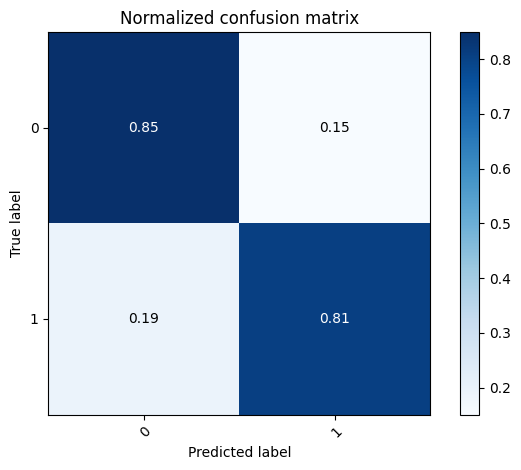

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con PCA

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8367    0.7736    0.8039        53
           1     0.7857    0.8462    0.8148        52

    accuracy                         0.8095       105
   macro avg     0.8112    0.8099    0.8094       105
weighted avg     0.8115    0.8095    0.8093       105

Roc auc score del modelo: 0.8864296081277213


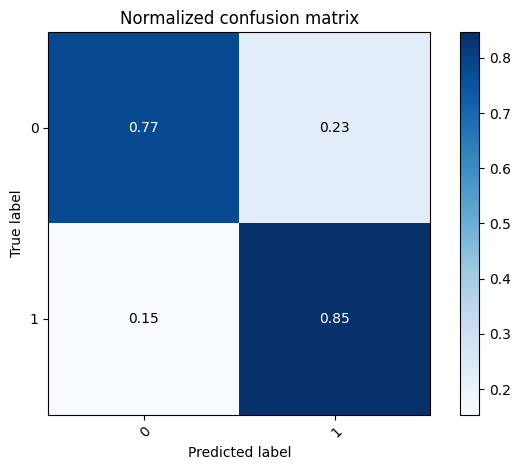

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X = X_train_pca, y = y_train)
y_pred = gboost.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in gboost.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_dist = {"n_estimators": [10,50,100,150,200],
              "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              "criterion": ['friedman_mse', 'squared_error'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None],
              "loss": ['log_loss', 'exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
random = RandomizedSearchCV(estimator = gboost, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8406666666666667
Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 23, 'n_estimators': 10}


Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.07692308 0.92307692]]
              precision    recall  f1-score   support

           0     0.9091    0.7547    0.8247        53
           1     0.7869    0.9231    0.8496        52

    accuracy                         0.8381       105
   macro avg     0.8480    0.8389    0.8371       105
weighted avg     0.8486    0.8381    0.8370       105

Roc auc score del modelo: 0.8457910014513788


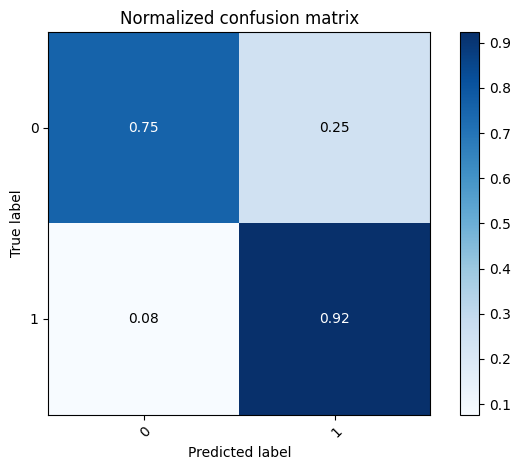

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [5,10,20,50],
              "learning_rate": [0.1,0.2,0.3],
              "criterion": ['friedman_mse', 'squared_error'],
              "max_depth": [2,4,8,16],
              "min_samples_split": [10,15,23,30,40],
              "min_samples_leaf": [3,5,7,10,15],
              "max_features": ['sqrt', 'log2', None],
              "loss": ['log_loss', 'exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(estimator = gboost, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_pca, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8736666666666666
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 23, 'n_estimators': 20}


Normalized confusion matrix
[[0.71698113 0.28301887]
 [0.09615385 0.90384615]]
              precision    recall  f1-score   support

           0     0.8837    0.7170    0.7917        53
           1     0.7581    0.9038    0.8246        52

    accuracy                         0.8095       105
   macro avg     0.8209    0.8104    0.8081       105
weighted avg     0.8215    0.8095    0.8080       105

Roc auc score del modelo: 0.841799709724238


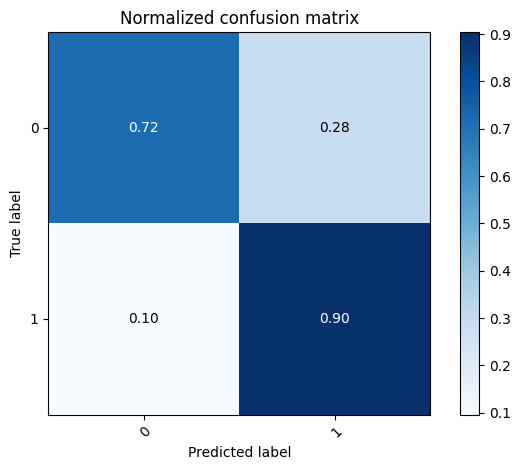

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_pca, y = y_train)
y_pred = modelo.predict(X_test_pca)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_pca)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

### Datos con UMAP

Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8333    0.7547    0.7921        53
           1     0.7719    0.8462    0.8073        52

    accuracy                         0.8000       105
   macro avg     0.8026    0.8004    0.7997       105
weighted avg     0.8029    0.8000    0.7996       105

Roc auc score del modelo: 0.8543178519593615


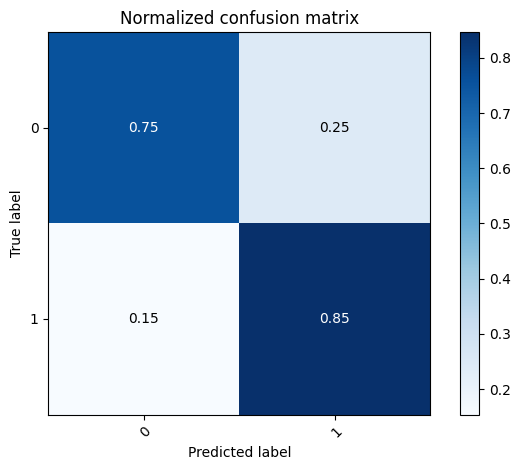

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X = X_train_umap, y = y_train)
y_pred = gboost.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in gboost.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**RandomizedSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_dist = {"n_estimators": [10,50,100,150,200],
              "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              "criterion": ['friedman_mse', 'squared_error'],
              "max_depth": [16, 12,8,4, 2,None],
              "min_samples_split": randint(2, 50),
              "min_samples_leaf": randint(1, 50),
              "max_features": ['sqrt', 'log2', None],
              "loss": ['log_loss', 'exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
random = RandomizedSearchCV(estimator = gboost, param_distributions = param_dist, n_iter = 100, cv = cval, n_jobs = -1, scoring = 'accuracy')
result = random.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para RandomizedSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch: ", result.best_params_)

Mejor accuracy para RandomizedSearchCV:  0.8155000000000001
Mejores hiperparámetros encontrados para Gradient Boosting mediante RandomizedSearch:  {'criterion': 'squared_error', 'learning_rate': 0.3, 'loss': 'exponential', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 36, 'n_estimators': 100}


Normalized confusion matrix
[[0.73584906 0.26415094]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8298    0.7358    0.7800        53
           1     0.7586    0.8462    0.8000        52

    accuracy                         0.7905       105
   macro avg     0.7942    0.7910    0.7900       105
weighted avg     0.7945    0.7905    0.7899       105

Roc auc score del modelo: 0.8575834542815676


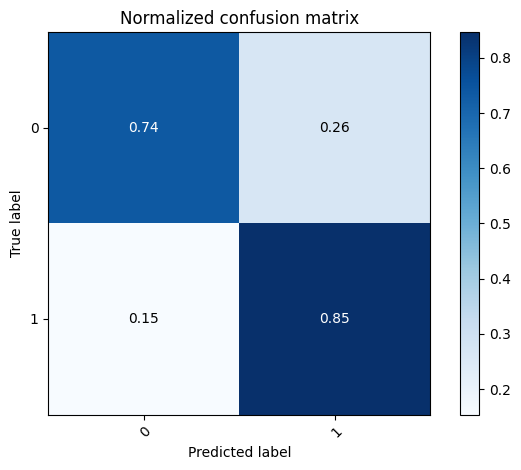

In [ ]:
modelo = random.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

**GridSearch**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_dist = {"n_estimators": [50, 100, 150],
              "learning_rate": [0.2, 0.3, 0.4],
              "criterion": ['squared_error'],
              "max_depth": [None,2,4,8],
              "min_samples_split": [30,36,45],
              "min_samples_leaf": [15,20,25],
              "max_features": ['log2'],
              "loss": ['log_loss', 'exponential']
            }

cval = KFold(n_splits = 10, shuffle = True, random_state = 42)

gboost = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(estimator = gboost, param_grid = param_dist, cv = cval, scoring = 'accuracy')
result = grid.fit(X = X_train_umap, y = y_train)

print("Mejor accuracy para GridSearchCV: ", result.best_score_)
print("Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV: ", result.best_params_)

Mejor accuracy para GridSearchCV:  0.8236666666666668
Mejores hiperparámetros encontrados para RandomForest mediante GridSearchCV:  {'criterion': 'squared_error', 'learning_rate': 0.4, 'loss': 'exponential', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 30, 'n_estimators': 50}


Normalized confusion matrix
[[0.73584906 0.26415094]
 [0.15384615 0.84615385]]
              precision    recall  f1-score   support

           0     0.8298    0.7358    0.7800        53
           1     0.7586    0.8462    0.8000        52

    accuracy                         0.7905       105
   macro avg     0.7942    0.7910    0.7900       105
weighted avg     0.7945    0.7905    0.7899       105

Roc auc score del modelo: 0.8691944847605225


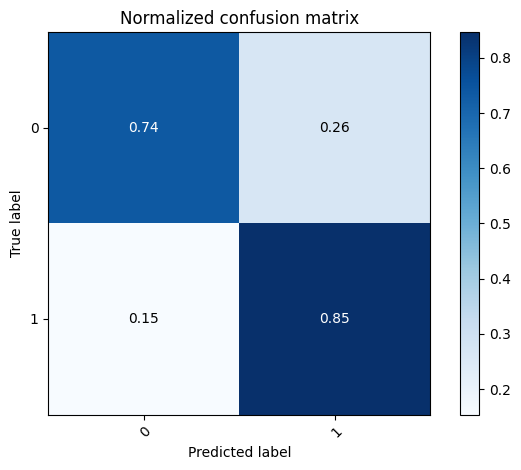

In [ ]:
modelo = grid.best_estimator_
modelo.fit(X = X_train_umap, y = y_train)
y_pred = modelo.predict(X_test_umap)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in modelo.predict_proba(X_test_umap)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Resultados datos iniciales

| Modelo | Variante | Accuracy test | AUC test |
| --- | --- | --- | --- |
| Regresión logística | Sin optimizar | 0.8476 | 0.9023
| Regresión logística | Elasticnet Random Search| 0.8667 | 0.9096
| Regresión logística | Elasticnet Grid Search| 0.8667 | 0.9092
| Regresión logística | L1 Random Search | 0.8667 | 0.9085
| Regresión logística | L1 Grid Search | 0.8667 | 0.9078
| Árboles de decisión | Sin optimizar | 0.7524 | 0.7514
| Árboles de decisión | Random Search | 0.7333 | 0.8071
| Árboles de decisión | Grid Search | 0.7333 | 0.8129
| SVM | Sin optimizar | 0.8571 | 0.9031
| SVM | Random Search | 0.9905 | 1.0
| SVM | Grid Search | 0.9905 | 1.0
| Random Forest | Sin optimizar | 0.8571 | 0.9350
| Random Forest | Random Search | 0.8857 | 0.9252
| Random Forest | Grid Search | 0.8857 | 0.9252
| AdaBoost | Sin optimizar | 0.8286 | 0.8958
| AdaBoost | Random Search | 0.8476 | 0.9151
| AdaBoost | Grid Search | 0.8286 | 0.9274
| Gradient Boosting | Sin optimizar | 0.8286 | 0.9245
| Gradient Boosting | Random Search | 0.8571 | 0.9401
| Gradient Boosting | Grid Search | 0.8286 | 0.9147


## SHAP: Relevancia de características

Se calcula entonces mediante la técnica SHAP la explicabilidad del modelo, es decir, la relevancia de cada una de las características. Se van a graficar también estas mediante un gráfico de cascada, que muestre la relevancia de las características en el primer ejemplo; y mediante un 'beeswharm' que muestre la relevancia en todos los ejemplos en conjunto.

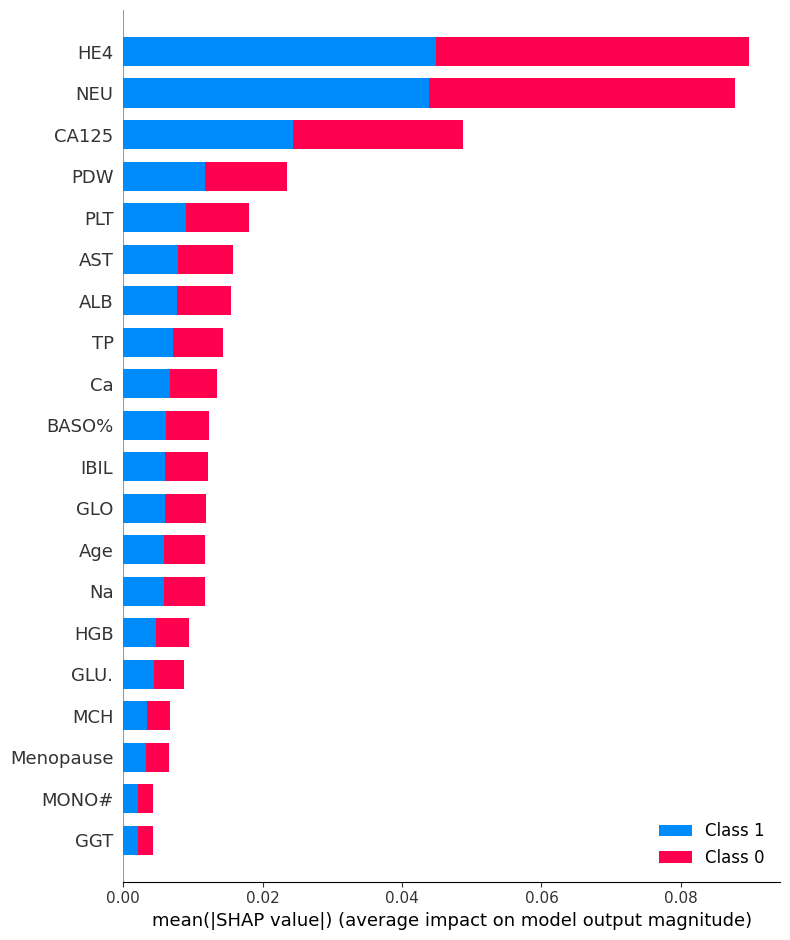

In [46]:
explainer = shap.TreeExplainer(ada)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_test)

# Prueba 1: Resultados con datos sin preprocesar

## Preparación de los datos

Para llevar a cabo estos modelos se va a realizar únicamente la limpieza de sus valores nulos sustituyendo estos por la media, lo cuál de primeras y sin haber llegado a valorar los datos atípicos no es lo más correcto, pero si lo básico.

<Axes: >

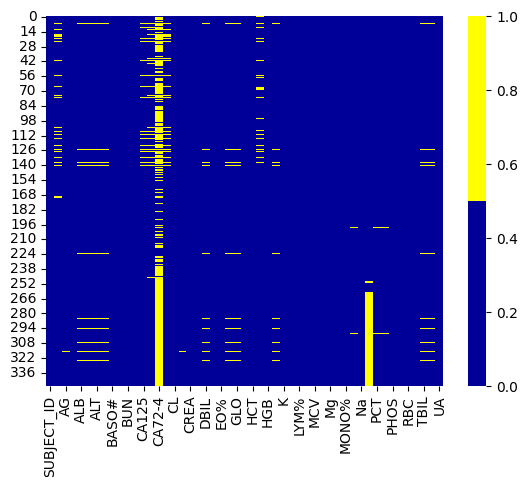

In [ ]:
colours = ['#000099', '#ffff00']
sns.heatmap(cancer_data.isnull(), cmap=sns.color_palette(colours))

In [ ]:
ratio = cancer_data.isnull().mean()
print(ratio)

SUBJECT_ID    0.000000
AFP           0.063037
AG            0.002865
Age           0.000000
ALB           0.028653
ALP           0.028653
ALT           0.028653
AST           0.028653
BASO#         0.000000
BASO%         0.000000
BUN           0.000000
Ca            0.000000
CA125         0.048711
CA19-9        0.068768
CA72-4        0.687679
CEA           0.063037
CL            0.000000
CO2CP         0.002865
CREA          0.000000
TYPE          0.000000
DBIL          0.028653
EO#           0.000000
EO%           0.000000
GGT           0.028653
GLO           0.028653
GLU.          0.000000
HCT           0.000000
HE4           0.057307
HGB           0.000000
IBIL          0.028653
K             0.000000
LYM#          0.000000
LYM%          0.000000
MCH           0.000000
MCV           0.000000
Menopause     0.000000
Mg            0.000000
MONO#         0.000000
MONO%         0.000000
MPV           0.005731
Na            0.000000
NEU           0.260745
PCT           0.005731
PDW        

Se eliminará también la columna 'CA72-4' por coherencia.

In [ ]:
cancer_data.drop(columns = ['CA72-4'], inplace = True)
cancer_data.fillna(cancer_data.mean(), inplace = True)

Por último, se va únicamente a realizar la división de los datos, sin haber normalizado estos. También se eliminará la columna 'SUBJECT_ID', ya que aún siendo el propósito de esta prueba encontrar diferencias, carece de sentido entrenar los modelos con esta columna presente.

In [ ]:
cancer_data.drop(columns = 'SUBJECT_ID', inplace = True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_sinp, X_test_sinp, y_train_sinp, y_test_sinp = train_test_split(cancer_data.drop(columns = ['TYPE']), cancer_data['TYPE'], test_size=0.3, random_state=42)

Ahora bien, para simplificar los cálculos se evalúa para cada modelo el modelo óptimo obtenido mediante los datos bien preprocesados en el apartado anterior.

## Regresión logística

#### Regularization elasticnet (L1 + L2)

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8776    0.8113    0.8431        53
           1     0.8214    0.8846    0.8519        52

    accuracy                         0.8476       105
   macro avg     0.8495    0.8480    0.8475       105
weighted avg     0.8498    0.8476    0.8475       105

Roc auc score del modelo: 0.8929608127721335


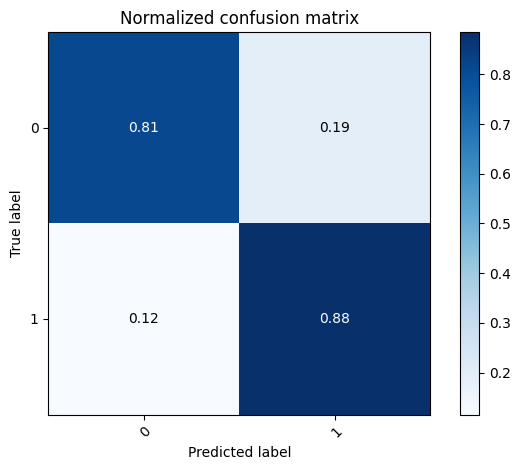

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

clf = LogisticRegression(penalty = 'elasticnet', C = 100, l1_ratio = 0, max_iter = 10000, solver = 'saga', random_state = 42)
clf.fit(X = X_train_sinp, y = y_train_sinp)
y_pred = clf.predict(X_test_sinp)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in clf.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

#### Regularization L2

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.19230769 0.80769231]]
              precision    recall  f1-score   support

           0     0.8039    0.7736    0.7885        53
           1     0.7778    0.8077    0.7925        52

    accuracy                         0.7905       105
   macro avg     0.7908    0.7906    0.7905       105
weighted avg     0.7910    0.7905    0.7904       105

Roc auc score del modelo: 0.8378084179970973


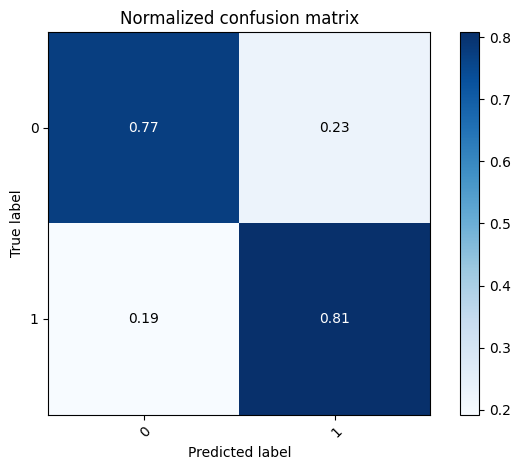

In [ ]:
clfl2 = LogisticRegression(penalty = 'l2', C = 100, max_iter = 100, solver = 'liblinear', random_state = 42)
clfl2.fit(X = X_train_sinp, y = y_train_sinp)
y_pred = clfl2.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in clfl2.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Árboles de decisión

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8776    0.8113    0.8431        53
           1     0.8214    0.8846    0.8519        52

    accuracy                         0.8476       105
   macro avg     0.8495    0.8480    0.8475       105
weighted avg     0.8498    0.8476    0.8475       105

Roc auc score del modelo: 0.8838896952104499


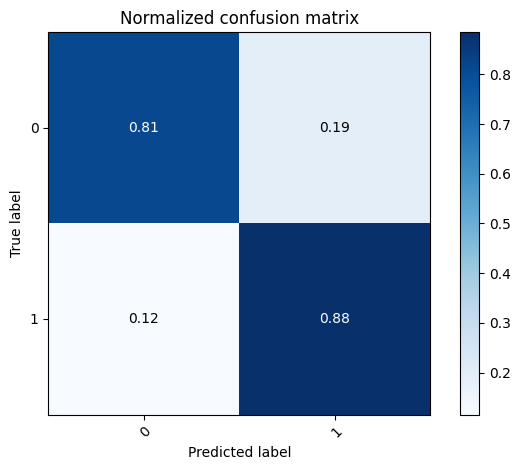

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
tree.fit(X_train_sinp, y_train_sinp)
y_pred = tree.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in tree.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Support Vector Machine (SVM)

Normalized confusion matrix
[[0.77358491 0.22641509]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8723    0.7736    0.8200        53
           1     0.7931    0.8846    0.8364        52

    accuracy                         0.8286       105
   macro avg     0.8327    0.8291    0.8282       105
weighted avg     0.8331    0.8286    0.8281       105

Roc auc score del modelo: 0.8759071117561683


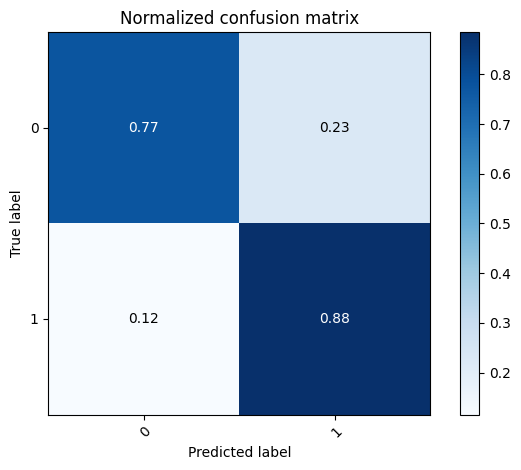

In [ ]:
from sklearn.svm import SVC

svm = SVC(C = 4, degree = 1, gamma = 'scale', kernel = 'rbf', random_state = 42, probability=True)
svm.fit(X_train_sinp, y_train_sinp)
y_pred = svm.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in svm.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Random Forest

Normalized confusion matrix
[[0.83018868 0.16981132]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9362    0.8302    0.8800        53
           1     0.8448    0.9423    0.8909        52

    accuracy                         0.8857       105
   macro avg     0.8905    0.8862    0.8855       105
weighted avg     0.8909    0.8857    0.8854       105

Roc auc score del modelo: 0.9354136429608128


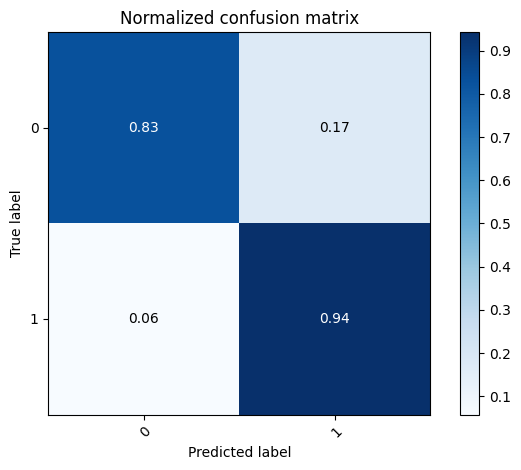

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 10, max_features = 'sqrt', min_samples_leaf = 23, min_samples_split = 40, n_estimators = 32, random_state = 42)
forest.fit(X = X_train_sinp, y = y_train_sinp)
y_pred = forest.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in forest.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Adaboost

Normalized confusion matrix
[[0.83018868 0.16981132]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9362    0.8302    0.8800        53
           1     0.8448    0.9423    0.8909        52

    accuracy                         0.8857       105
   macro avg     0.8905    0.8862    0.8855       105
weighted avg     0.8909    0.8857    0.8854       105

Roc auc score del modelo: 0.9542815674891147


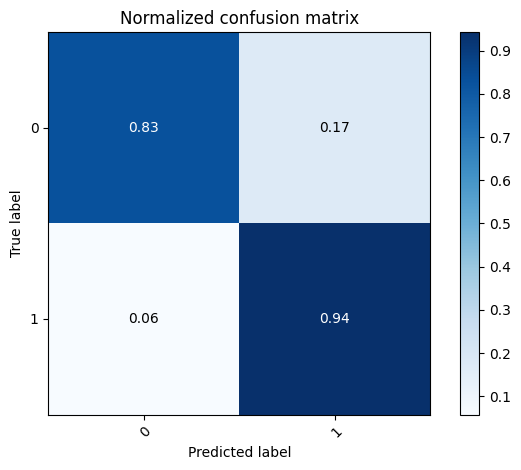

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
ada = AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 1, n_estimators = 32, estimator = tree, random_state = 42)

ada.fit(X = X_train_sinp, y = y_train_sinp)
y_pred = ada.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Gradient Boosting

Normalized confusion matrix
[[0.83018868 0.16981132]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8800    0.8302    0.8544        53
           1     0.8364    0.8846    0.8598        52

    accuracy                         0.8571       105
   macro avg     0.8582    0.8574    0.8571       105
weighted avg     0.8584    0.8571    0.8571       105

Roc auc score del modelo: 0.9332365747460087


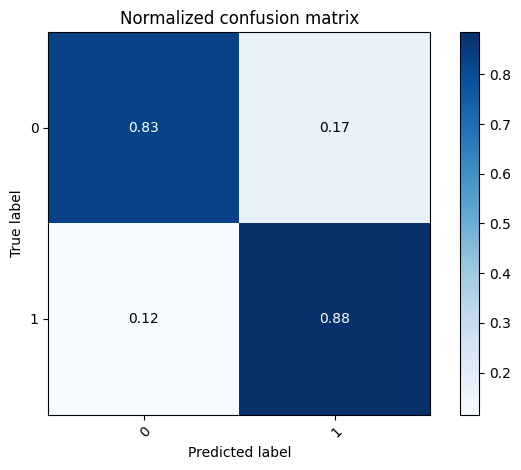

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(criterion = 'friedman_mse', learning_rate = 0.25, loss = 'exponential', max_depth = None, max_features = None, min_samples_leaf = 16, min_samples_split = 31, n_estimators = 50, random_state=42)
gboost.fit(X = X_train_sinp, y = y_train_sinp)
y_pred = gboost.predict(X_test_sinp)

plot_confusion_matrix(y_test_sinp, y_pred, classes = unique_labels(y_test_sinp, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test_sinp, y_pred, digits = 4))

preds = [i[1] for i in gboost.predict_proba(X_test_sinp)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test_sinp, preds)}")

## Resultados

| Modelo | Accuracy test | AUC test |
| --- | --- | --- |
| Regresión logística Elasticnet | 0.8095 | 0.8603
| Regresión logística L1/L2 | 0.8095 | 0.8563
| Árboles de decisión | 0.8476 | 0.8838
| SVM | 0.8286 | 0.8886
| Random Forest | 0.8857 | 0.9361
| AdaBoost | 0.8857 | 0.9542
| Gradient Boosting | 0.8571 | 0.9314


# Prueba 2: Aumento de datos

Se va a realizar ahora la prueba de ejecutar de nuevo todos los algoritmos utilizando previamente una técnica de aumento de datos mediante la perturbación de características continuas añadiendo ruido gaussiano en las características menos correlacionadas con la variable objetivo _'TYPE'_.

## Preparación de los datos

**Perturbación de Características Continuas**

In [ ]:
def add_gaussian_noise(df, columns, mean=0, std=0.1):
    df_augmented = cancer_data.copy()
    for column in columns:
        noise = np.random.normal(loc=mean, scale = std, size=cancer_data[column].shape)
        df_augmented[column] += noise
    return df_augmented

#Se utilizan las características menos correlacionadas con 'TYPE'
features = ['BASO%', 'GGT']
features2 = ['PDW', 'Na']

df_augmented = add_gaussian_noise(cancer_data, columns=features, mean=0, std=0.1)
df_augmented2 = add_gaussian_noise(cancer_data, columns=features, mean=0, std=0.05)
cancer_data_augmented = pd.concat([cancer_data, df_augmented, df_augmented2], ignore_index=True)

**Normalización de los datos**

In [ ]:
scaler = preprocessing.MinMaxScaler()

columns = cancer_data_augmented.drop(columns = ['Menopause', 'TYPE'], axis = 1).columns
x_cancer_data = scaler.fit_transform(cancer_data_augmented.drop(['Menopause', 'TYPE'], axis = 1))
x_cancer_data = pd.DataFrame(x_cancer_data, columns = columns)
x_cancer_data.insert(loc=0, column = 'Menopause', value=cancer_data_augmented['Menopause'])

y_cancer_data = cancer_data_augmented['TYPE']


**División de los datos**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_cancer_data, y_cancer_data, test_size=0.2, random_state=42)

In [ ]:
print(f"El tamaño del dataset de entrenamiento será de:", X_train.shape)
print(f"El tamaño del dataset de prueba será de:", X_test.shape)

El tamaño del dataset de entrenamiento será de: (837, 23)
El tamaño del dataset de prueba será de: (210, 23)


Se vuelven a ejecutar los algoritmos que se han obtenido como óptimos a partir de los datos bien preprocesados y sin aplicar ninguna técnica de aumento de datos. Esto se hará también por simplificar los cálculos.

## Regresión logística

#### Regularization elasticnet (L1 + L2)

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8776    0.8113    0.8431       106
           1     0.8214    0.8846    0.8519       104

    accuracy                         0.8476       210
   macro avg     0.8495    0.8480    0.8475       210
weighted avg     0.8498    0.8476    0.8475       210

Roc auc score del modelo: 0.9228955007256895


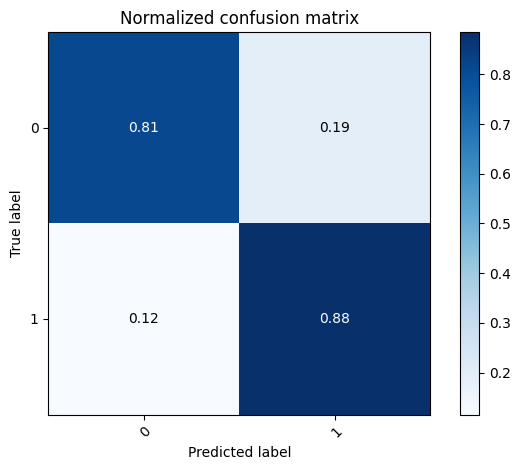

In [ ]:
clf = LogisticRegression(penalty = 'elasticnet', C = 100, l1_ratio = 0, max_iter = 10000, solver = 'saga', random_state = 42)
clf.fit(X = X_train, y = y_train)
y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in clf.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

#### Regularization L2

Normalized confusion matrix
[[0.81132075 0.18867925]
 [0.11538462 0.88461538]]
              precision    recall  f1-score   support

           0     0.8776    0.8113    0.8431       106
           1     0.8214    0.8846    0.8519       104

    accuracy                         0.8476       210
   macro avg     0.8495    0.8480    0.8475       210
weighted avg     0.8498    0.8476    0.8475       210

Roc auc score del modelo: 0.9233490566037736


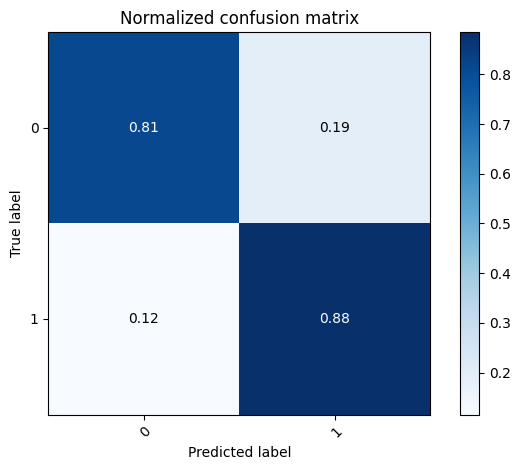

In [ ]:
clfl2 = LogisticRegression(penalty = 'l2', C = 100, max_iter = 100, solver = 'liblinear', random_state = 42)
clfl2.fit(X = X_train, y = y_train)
y_pred = clfl2.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in clfl2.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Árboles de decisión

Normalized confusion matrix
[[0.82075472 0.17924528]
 [0.13461538 0.86538462]]
              precision    recall  f1-score   support

           0     0.8614    0.8208    0.8406       106
           1     0.8257    0.8654    0.8451       104

    accuracy                         0.8429       210
   macro avg     0.8435    0.8431    0.8428       210
weighted avg     0.8437    0.8429    0.8428       210

Roc auc score del modelo: 0.8805333817126271


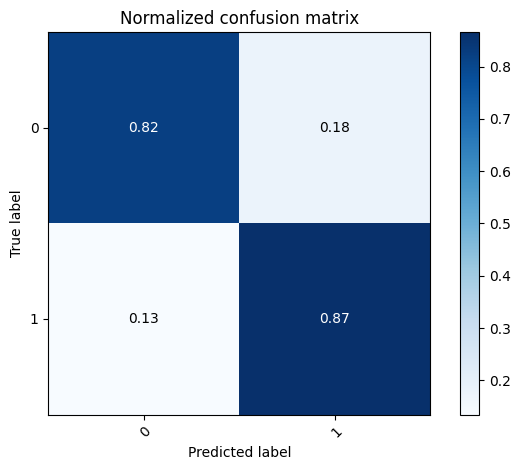

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in tree.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Support Vector Machine (SVM)

Normalized confusion matrix
[[0.86792453 0.13207547]
 [0.01923077 0.98076923]]
              precision    recall  f1-score   support

           0     0.9787    0.8679    0.9200       106
           1     0.8793    0.9808    0.9273       104

    accuracy                         0.9238       210
   macro avg     0.9290    0.9243    0.9236       210
weighted avg     0.9295    0.9238    0.9236       210

Roc auc score del modelo: 0.9678882438316401


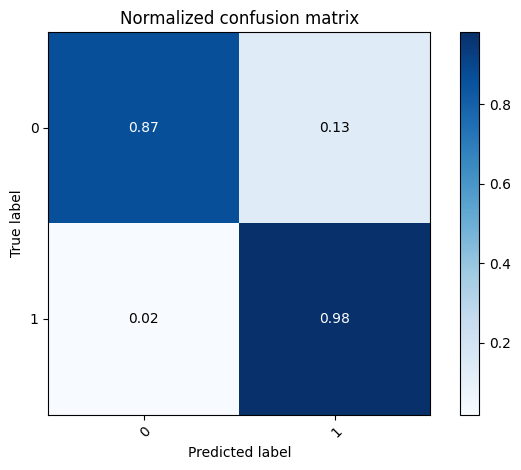

In [ ]:
from sklearn.svm import SVC

svm = SVC(C = 4, degree = 1, gamma = 'scale', kernel = 'rbf', random_state = 42, probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in svm.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Random Forest

Normalized confusion matrix
[[0.86792453 0.13207547]
 [0.03846154 0.96153846]]
              precision    recall  f1-score   support

           0     0.9583    0.8679    0.9109       106
           1     0.8772    0.9615    0.9174       104

    accuracy                         0.9143       210
   macro avg     0.9178    0.9147    0.9142       210
weighted avg     0.9181    0.9143    0.9141       210

Roc auc score del modelo: 0.9610849056603774


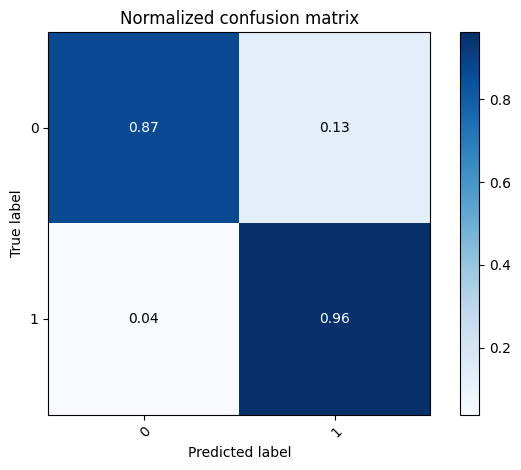

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 10, max_features = 'sqrt', min_samples_leaf = 23, min_samples_split = 40, n_estimators = 32, random_state = 42)
forest.fit(X = X_train, y = y_train)
y_pred = forest.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in forest.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Adaboost

Normalized confusion matrix
[[1.         0.        ]
 [0.05769231 0.94230769]]
              precision    recall  f1-score   support

           0     0.9464    1.0000    0.9725       106
           1     1.0000    0.9423    0.9703       104

    accuracy                         0.9714       210
   macro avg     0.9732    0.9712    0.9714       210
weighted avg     0.9730    0.9714    0.9714       210

Roc auc score del modelo: 1.0


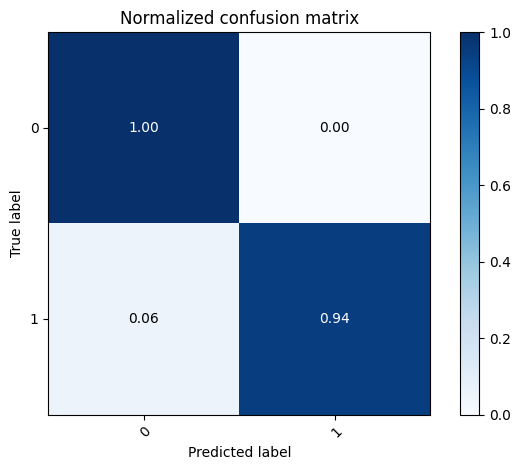

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, max_features = None, min_samples_leaf = 30, min_samples_split = 20, splitter = 'best', random_state = 42)
ada = AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 1, n_estimators = 32, estimator = tree, random_state = 42)

ada.fit(X = X_train, y = y_train)
y_pred = ada.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in ada.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Gradient Boosting

Normalized confusion matrix
[[0.97169811 0.02830189]
 [0.02884615 0.97115385]]
              precision    recall  f1-score   support

           0     0.9717    0.9717    0.9717       106
           1     0.9712    0.9712    0.9712       104

    accuracy                         0.9714       210
   macro avg     0.9714    0.9714    0.9714       210
weighted avg     0.9714    0.9714    0.9714       210

Roc auc score del modelo: 0.9980950653120464


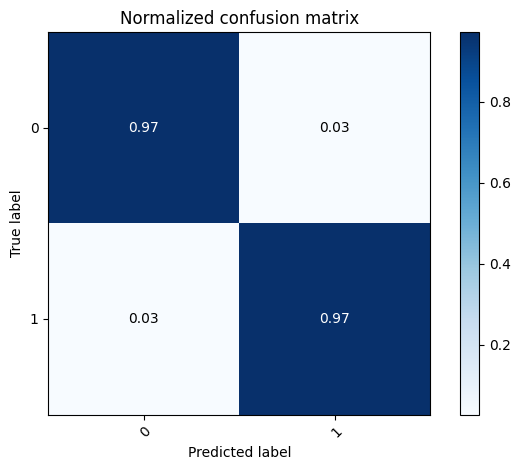

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(criterion = 'friedman_mse', learning_rate = 0.25, loss = 'exponential', max_depth = None, max_features = None, min_samples_leaf = 16, min_samples_split = 31, n_estimators = 50, random_state=42)
gboost.fit(X = X_train, y = y_train)
y_pred = gboost.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, digits = 4))

preds = [i[1] for i in gboost.predict_proba(X_test)]
print(f"Roc auc score del modelo: {roc_auc_score(y_test, preds)}")

## Resultados

| Modelo | Accuracy test | AUC test |
| --- | --- | --- |
| Regresión logística Elasticnet | 0.8476 | 0.9228
| Regresión logística L1 | 0.8476 | 0.9233
| Árboles de decisión | 0.8429 | 0.8805
| SVM | 0.9238 | 0.9678
| Random Forest | 0.9143 | 0.9610
| AdaBoost | 0.9714 | 1.0
| Gradient Boosting | 0.9714 | 0.9980
